In [1]:
# ============================================================================
# SECTION 0: REQUIRED PACKAGES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
import copy
from copy import deepcopy
from dsgepy import DSGE
from fredapi import Fred
from sympy import symbols, Matrix
import pickle
from scipy import stats, signal, linalg
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.linalg as slinalg
from scipy.linalg import solve_discrete_lyapunov
from scipy.signal import savgol_filter
from darts import TimeSeries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from scipy.optimize import minimize, minimize_scalar, differential_evolution
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# ============================================================================
# DFM DSGE-Style Estimation
# ============================================================================

In [2]:
# Core Dynamic Factor Model - Essential Estimation Only
# Suppress warnings for cleaner output
# FRED API Setup
afkey = 'ada1a8ba0569ed784226f2c26db44ab1'  # Replace with your FRED API key
fred = Fred(api_key=afkey)

# Economically structured blocks with consistent shock treatment
economic_blocks = {
    'Demand_Block': {
        'trend_cyclical': ['GDPC1', 'PAYEMS', 'INDPRO'],  # Growth rates
        'shock': ['ICSA']  # Level (inverse shock indicator)
    },

    'Supply_Block': {
        'trend_cyclical': ['CPIAUCSL', 'PCEPI', 'AHETPI'],  # Growth rates
        'shock': ['DCOILWTICO']  # Level (supply shock)
    },

    'Monetary_Block': {
        'trend_cyclical': ['FEDFUNDS', 'DGS10', 'M2SL'],  # Mix of levels and growth
        'shock': ['AAA']  # Level (financial stress indicator)
    }
}

def fetch_series_robust(series_id, start_date, fred_api):
    """Robust series fetching with comprehensive error handling"""
    try:
        series = fred_api.get_series(series_id, start_date)
        if series.empty or len(series) < 20:
            print(f"Warning: {series_id} insufficient data")
            return None

        series = series.dropna()
        series = series.to_frame(name=series_id)
        series.index = pd.to_datetime(series.index)
        return series
    except Exception as e:
        print(f"Failed to fetch {series_id}: {e}")
        return None

def prepare_econometric_data(start_date="2000-01-01"):
    """Prepare data with econometrically consistent transformations"""
    print("Fetching economic data from FRED...")

    all_series = {}

    # Fetch all series
    for block_name, block_data in economic_blocks.items():
        print(f"\nFetching {block_name}:")

        for var_type in ['trend_cyclical', 'shock']:
            for series_id in block_data[var_type]:
                data = fetch_series_robust(series_id, start_date, fred)
                if data is not None:
                    all_series[series_id] = data
                    print(f"  {series_id} ✓ ({len(data)} obs)")
                else:
                    print(f"  {series_id} ✗")

    if len(all_series) < 8:  # Need most variables for robust estimation
        raise ValueError(f"Only {len(all_series)} series fetched. Need at least 8.")

    print(f"\nSuccessfully fetched {len(all_series)} series")

    # Find common time range
    all_start_dates = [s.index.min() for s in all_series.values()]
    all_end_dates = [s.index.max() for s in all_series.values()]

    common_start = max(all_start_dates)
    common_end = min(all_end_dates)

    print(f"Common date range: {common_start.strftime('%Y-%m')} to {common_end.strftime('%Y-%m')}")

    # Create quarterly index
    quarterly_index = pd.date_range(
        start=common_start.replace(day=1),
        end=common_end,
        freq='Q'
    )

    print(f"Quarterly observations: {len(quarterly_index)}")

    # Process series with econometrically consistent transformations
    quarterly_data = pd.DataFrame(index=quarterly_index)

    for series_id, series_data in all_series.items():
        series_trimmed = series_data[common_start:common_end].copy()

        # Determine transformation based on economic theory
        if series_id in ['GDPC1', 'PAYEMS', 'INDPRO']:
            # Real activity: QoQ annualized growth rates
            quarterly_last = series_trimmed.resample('Q').last()
            quarterly_series = (quarterly_last.pct_change(1) * 400)  # Annualized QoQ

        elif series_id in ['CPIAUCSL', 'PCEPI', 'AHETPI']:
            # Prices/wages: YoY growth rates (standard for inflation)
            quarterly_last = series_trimmed.resample('Q').last()
            quarterly_series = quarterly_last.pct_change(4) * 100  # YoY %

        elif series_id == 'M2SL':
            # Money supply: YoY growth rate
            quarterly_last = series_trimmed.resample('Q').last()
            quarterly_series = quarterly_last.pct_change(4) * 100  # YoY %

        elif series_id in ['FEDFUNDS', 'DGS10']:
            # Interest rates: levels (already in percentage terms)
            quarterly_series = series_trimmed.resample('Q').last()

        elif series_id == 'ICSA':
            # Initial claims: level (weekly average, inverse demand shock)
            quarterly_series = series_trimmed.resample('Q').mean()
            # Transform to make it a positive demand indicator
            quarterly_series = -np.log(quarterly_series)  # Negative log for inverse relationship

        elif series_id == 'DCOILWTICO':
            # Oil prices: log level (shock variable, variance stabilized)
            quarterly_last = series_trimmed.resample('Q').last()
            quarterly_series = np.log(quarterly_last.replace(0, np.nan))  # Log level

        elif series_id == 'AAA':
            # Credit spread: level (financial stress indicator)
            quarterly_series = series_trimmed.resample('Q').last()

        # Align to quarterly index
        quarterly_data[series_id] = quarterly_series.reindex(quarterly_index)

    # Remove rows with too many missing values
    quarterly_data = quarterly_data.dropna(thresh=len(quarterly_data.columns) * 0.7)

    # Forward fill remaining missing values
    quarterly_data = quarterly_data.fillna(method='ffill').fillna(method='bfill')

    print(f"Final dataset shape: {quarterly_data.shape}")
    print(f"Date range: {quarterly_data.index[0].strftime('%Y-Q%q')} to {quarterly_data.index[-1].strftime('%Y-Q%q')}")

    # Organize into blocks based on what we actually got
    organized_blocks = {}
    for block_name, block_data in economic_blocks.items():
        all_block_vars = block_data['trend_cyclical'] + block_data['shock']
        available_vars = [v for v in all_block_vars if v in quarterly_data.columns]

        if len(available_vars) > 0:
            organized_blocks[block_name] = quarterly_data[available_vars]
            print(f"{block_name}: {available_vars}")
    return organized_blocks, quarterly_data


class EconometricDFM:
    """
    Core Econometric Dynamic Factor Model for Estimation

    Essential functionality:
    1. Factor extraction via PCA
    2. Factor loading estimation
    3. VAR estimation for factor dynamics
    4. Forecasting with confidence intervals
    5. Cross-validation with comprehensive metrics
    """

    def __init__(self, organized_blocks, combined_data):
        self.organized_blocks = organized_blocks
        self.combined_data = combined_data.copy()

        # Store block structure for identification
        self.block_structure = {}
        var_counter = 0

        for block_name, block_data in organized_blocks.items():
            n_vars = len(block_data.columns)
            self.block_structure[block_name] = {
                'variables': list(block_data.columns),
                'start_idx': var_counter,
                'end_idx': var_counter + n_vars,
                'size': n_vars
            }
            var_counter += n_vars

        self.N_vars = len(self.combined_data.columns)
        self.T_obs = len(self.combined_data)
        self.n_factors = min(3, len(self.block_structure))  # One factor per block

        print(f"\nEconometric DFM Setup:")
        print(f"  Variables: {self.N_vars}")
        print(f"  Observations: {self.T_obs}")
        print(f"  Factors: {self.n_factors}")

        # Standardize data properly
        self.scaler = StandardScaler()
        self.data_standardized = pd.DataFrame(
            self.scaler.fit_transform(self.combined_data),
            index=self.combined_data.index,
            columns=self.combined_data.columns
        )

        # Define variable scales and types for cross-validation output
        self.variable_info = {
            'GDPC1': {'name': 'GDP (Billions $)', 'typical_scale': 20000, 'type': 'level'},
            'PAYEMS': {'name': 'EMPLOYMENT (Thousands)', 'typical_scale': 150000, 'type': 'level'},
            'INDPRO': {'name': 'INDUSTRIAL PRODUCTION (Index)', 'typical_scale': 100, 'type': 'index'},
            'ICSA': {'name': 'INITIAL CLAIMS (Thousands)', 'typical_scale': 300, 'type': 'level'},
            'CPIAUCSL': {'name': 'INFLATION (Index)', 'typical_scale': 250, 'type': 'index'},
            'PCEPI': {'name': 'PCE INFLATION (Index)', 'typical_scale': 110, 'type': 'index'},
            'AHETPI': {'name': 'WAGES (Dollars/Hour)', 'typical_scale': 25, 'type': 'level'},
            'DCOILWTICO': {'name': 'OIL PRICES ($/Barrel)', 'typical_scale': 60, 'type': 'level'},
            'FEDFUNDS': {'name': 'INTEREST RATE (Percent)', 'typical_scale': 5, 'type': 'rate'},
            'DGS10': {'name': '10Y TREASURY (Percent)', 'typical_scale': 5, 'type': 'rate'},
            'M2SL': {'name': 'MONEY SUPPLY (Billions $)', 'typical_scale': 15000, 'type': 'level'},
            'AAA': {'name': 'CREDIT SPREAD (Percent)', 'typical_scale': 4, 'type': 'rate'}
        }

        # Results storage
        self.factors = None
        self.loadings = None
        self.factor_var = None
        self.idiosyncratic_var = None

    def extract_factors_pca(self):
        """Extract factors using Principal Component Analysis"""
        print("\n" + "="*60)
        print("STEP 1: FACTOR EXTRACTION VIA PCA")
        print("="*60)

        # Apply PCA to standardized data
        pca = PCA(n_components=self.n_factors)
        factors_pca = pca.fit_transform(self.data_standardized)

        # Store factors with economic names
        factor_names = ['Demand_Factor', 'Supply_Factor', 'Monetary_Factor'][:self.n_factors]

        self.factors = pd.DataFrame(
            factors_pca,
            index=self.data_standardized.index,
            columns=factor_names
        )

        # Store loadings (PCA components)
        self.pca_loadings = pd.DataFrame(
            pca.components_.T,
            index=self.combined_data.columns,
            columns=factor_names
        )

        print(f"PCA explained variance: {pca.explained_variance_ratio_}")
        print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

        return self.factors

    def estimate_factor_loadings(self):
        """Estimate factor loadings via regression"""
        print("\n" + "="*60)
        print("STEP 2: FACTOR LOADING ESTIMATION")
        print("="*60)

        if self.factors is None:
            raise ValueError("Must extract factors first")

        # Estimate loadings: X_t = Λ F_t + ε_t
        X = self.data_standardized.values  # T x N
        F = self.factors.values           # T x r

        # OLS: Λ = (F'F)^(-1) F'X'
        FtF_inv = np.linalg.inv(F.T @ F)
        Lambda = (FtF_inv @ F.T @ X).T  # N x r

        # Calculate residuals and fit statistics
        X_fitted = F @ Lambda.T
        residuals = X - X_fitted

        # R-squared for each variable
        r_squared = np.zeros(self.N_vars)
        idiosyncratic_var = np.zeros(self.N_vars)

        for i in range(self.N_vars):
            ss_res = np.sum(residuals[:, i]**2)
            ss_tot = np.sum((X[:, i] - np.mean(X[:, i]))**2)
            r_squared[i] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            idiosyncratic_var[i] = np.var(residuals[:, i])

        self.loadings = pd.DataFrame(
            Lambda,
            index=self.combined_data.columns,
            columns=self.factors.columns
        )

        self.idiosyncratic_var = pd.Series(
            idiosyncratic_var,
            index=self.combined_data.columns
        )

        # Print basic results
        print("\nFactor Loading Results:")
        print("=" * 70)
        print(f"{'Variable':<12} {'R²':<6} {'Demand':<10} {'Supply':<10} {'Monetary':<10}")
        print("-" * 70)

        for i, var in enumerate(self.combined_data.columns):
            loadings_row = [Lambda[i, j] if j < Lambda.shape[1] else 0 for j in range(3)]
            print(f"{var:<12} {r_squared[i]:<6.3f} "
                  f"{loadings_row[0]:<10.3f} {loadings_row[1]:<10.3f} {loadings_row[2]:<10.3f}")

        print(f"\nAverage R²: {np.mean(r_squared):.3f}")
        return self.loadings

    def estimate_factor_var(self, max_lags=6, ic='bic'):
        """Estimate VAR model for factors with proper lag selection"""
        print("\n" + "="*60)
        print("STEP 3: FACTOR VAR ESTIMATION")
        print("="*60)

        if self.factors is None:
            raise ValueError("Must extract factors first")

        F = self.factors.values
        T, K = F.shape

        # Lag selection using information criteria
        optimal_lag = self._select_optimal_lag(F, max_lags, ic)
        print(f"Optimal lag selected: {optimal_lag} (using {ic.upper()})")

        # Estimate VAR(p) model
        self.factor_var = self._estimate_var_model(F, optimal_lag)

        # Check model stability
        self._check_var_stability()

        return self.factor_var

    def _select_optimal_lag(self, data, max_lags, criterion='bic'):
        """Select optimal VAR lag using information criteria"""
        T, K = data.shape
        max_feasible_lags = min(max_lags, T // (4 * K))  # Ensure sufficient degrees of freedom

        ic_values = []

        for p in range(1, max_feasible_lags + 1):
            try:
                var_result = self._estimate_var_model(data, p, verbose=False)
                T_eff = T - p

                # Calculate information criteria
                log_det_sigma = np.log(np.linalg.det(var_result['sigma_u']))
                n_params = K + K**2 * p  # Constants + VAR coefficients

                if criterion.lower() == 'aic':
                    ic = log_det_sigma + (2 * n_params) / T_eff
                elif criterion.lower() == 'bic':
                    ic = log_det_sigma + (n_params * np.log(T_eff)) / T_eff
                elif criterion.lower() == 'hqic':
                    ic = log_det_sigma + (2 * n_params * np.log(np.log(T_eff))) / T_eff
                else:
                    raise ValueError("Criterion must be 'aic', 'bic', or 'hqic'")

                ic_values.append((p, ic))

            except np.linalg.LinAlgError:
                continue

        if not ic_values:
            print(f"Warning: Could not estimate VAR models. Using lag=1")
            return 1

        # Select lag with minimum IC
        optimal_lag = min(ic_values, key=lambda x: x[1])[0]
        return optimal_lag

    def _estimate_var_model(self, data, lags, verbose=True):
        """Estimate VAR(p) model using OLS"""
        T, K = data.shape

        if T <= lags * K + K:
            raise ValueError(f"Insufficient observations for VAR({lags})")

        # Construct regression matrices
        Y = data[lags:, :]  # Dependent variables (T-p) x K
        T_eff = Y.shape[0]

        # Construct regressor matrix X
        X = np.ones((T_eff, 1))  # Constant term

        for lag in range(1, lags + 1):
            X = np.hstack([X, data[lags-lag:-lag, :]])  # Add lagged factors

        # OLS estimation: Y = X β + u
        XtX_inv = np.linalg.inv(X.T @ X)
        beta = XtX_inv @ X.T @ Y  # (1 + K*p) x K

        # Residuals and covariance matrix
        u = Y - X @ beta  # Residuals
        sigma_u = (u.T @ u) / T_eff  # Residual covariance matrix

        # Coefficient matrices
        const = beta[0, :]  # Constant terms
        var_coeffs = beta[1:, :].T  # K x (K*p) VAR coefficient matrix

        # Standard errors (for diagnostics)
        var_beta = np.kron(sigma_u, XtX_inv)
        se_beta = np.sqrt(np.diag(var_beta)).reshape(beta.shape)

        # Model statistics
        log_likelihood = self._compute_log_likelihood(u, sigma_u)

        if verbose:
            print(f"VAR({lags}) estimation completed:")
            print(f"  Effective sample: {T_eff}")
            print(f"  Log-likelihood: {log_likelihood:.2f}")

        return {
            'coefficients': var_coeffs,      # K x (K*p)
            'constant': const,               # K x 1
            'sigma_u': sigma_u,             # K x K residual covariance
            'residuals': u,                 # (T-p) x K
            'standard_errors': se_beta,     # Full parameter standard errors
            'log_likelihood': log_likelihood,
            'lags': lags,
            'T_eff': T_eff,
            'X_design': X,                  # Design matrix
            'Y_data': Y                     # Dependent variable matrix
        }

    def _compute_log_likelihood(self, residuals, sigma_u):
        """Compute log-likelihood for VAR model"""
        T, K = residuals.shape
        log_likelihood = -0.5 * T * K * np.log(2 * np.pi)
        log_likelihood -= 0.5 * T * np.log(np.linalg.det(sigma_u))
        log_likelihood -= 0.5 * np.trace(residuals.T @ residuals @ np.linalg.inv(sigma_u))
        return log_likelihood

    def _check_var_stability(self):
        """Check VAR model stability via companion matrix eigenvalues"""
        if self.factor_var is None:
            return False

        Phi = self.factor_var['coefficients']
        p = self.factor_var['lags']
        K = Phi.shape[0]

        # Construct companion matrix
        if p == 1:
            companion = Phi
        else:
            # For VAR(p): K*p x K*p companion matrix
            companion = np.zeros((K * p, K * p))
            companion[:K, :] = Phi  # Top block: VAR coefficients

            # Identity blocks for lagged terms
            for i in range(1, p):
                start_row, end_row = i * K, (i + 1) * K
                start_col, end_col = (i - 1) * K, i * K
                companion[start_row:end_row, start_col:end_col] = np.eye(K)

        # Check stability condition
        eigenvals = np.linalg.eigvals(companion)
        max_modulus = np.max(np.abs(eigenvals))
        is_stable = max_modulus < 1.0

        print(f"\nVAR Stability Check:")
        print(f"  Maximum eigenvalue modulus: {max_modulus:.4f}")
        print(f"  Model is {'stable' if is_stable else 'unstable'} {'✓' if is_stable else '✗'}")

        self.companion_matrix = companion
        self.eigenvalues = eigenvals
        return is_stable

    def forecast_var(self, horizon=8, confidence_level=0.95):
        """Generate VAR forecasts using companion form"""
        print("\n" + "="*60)
        print("VAR FORECASTING WITH COMPANION FORM")
        print("="*60)

        if self.factor_var is None:
            raise ValueError("Must estimate VAR model first")

        # Extract VAR parameters
        Phi = self.factor_var['coefficients']    # K x (K*p)
        c = self.factor_var['constant']          # K x 1
        Sigma = self.factor_var['sigma_u']       # K x K
        p = self.factor_var['lags']
        K = Phi.shape[0]

        print(f"Forecasting {K} factors for {horizon} periods using VAR({p})")

        # Analytical forecasting using companion form
        forecasts_analytical = self._forecast_companion_form(horizon)

        # Bootstrap forecasting for confidence intervals
        forecasts_bootstrap = self._forecast_bootstrap(horizon, n_bootstrap=500, confidence_level=confidence_level)

        # Combine results
        forecast_dates = pd.date_range(
            start=self.factors.index[-1] + pd.DateOffset(months=3),
            periods=horizon,
            freq='Q'
        )

        self.factor_forecasts = {
            'mean': pd.DataFrame(
                forecasts_analytical['mean'],
                index=forecast_dates,
                columns=self.factors.columns
            ),
            'analytical_std': pd.DataFrame(
                forecasts_analytical['std'],
                index=forecast_dates,
                columns=self.factors.columns
            ),
            'bootstrap_lower': pd.DataFrame(
                forecasts_bootstrap['lower'],
                index=forecast_dates,
                columns=self.factors.columns
            ),
            'bootstrap_upper': pd.DataFrame(
                forecasts_bootstrap['upper'],
                index=forecast_dates,
                columns=self.factors.columns
            )
        }

        print(f"\nForecast Summary (1-quarter ahead):")
        print("-" * 50)
        for i, factor in enumerate(self.factors.columns):
            mean_fcst = forecasts_analytical['mean'][0, i]
            std_fcst = forecasts_analytical['std'][0, i]
            print(f"{factor}: {mean_fcst:7.3f} ± {std_fcst:.3f}")

        return self.factor_forecasts

    def _forecast_companion_form(self, horizon):
        """Analytical VAR forecasting using companion matrix"""
        Phi = self.factor_var['coefficients']
        c = self.factor_var['constant']
        Sigma = self.factor_var['sigma_u']
        p = self.factor_var['lags']
        K = Phi.shape[0]

        # Initialize forecast arrays
        forecasts = np.zeros((horizon, K))
        forecast_variance = np.zeros((horizon, K))

        if p == 1:
            # VAR(1) case
            for h in range(horizon):
                if h == 0:
                    forecasts[h, :] = c + Phi @ self.factors.values[-1, :]
                    forecast_variance[h, :] = np.diag(Sigma)
                else:
                    forecasts[h, :] = c + Phi @ forecasts[h-1, :]
                    Phi_h = np.linalg.matrix_power(Phi, h)
                    forecast_variance[h, :] = np.diag(Phi_h @ Sigma @ Phi_h.T)
        else:
            # VAR(p) case - use companion form
            companion = self.companion_matrix
            K_comp = companion.shape[0]

            # Get initial conditions
            F_init = self.factors.values[-p:, :].flatten('F')
            z_init = np.zeros(K_comp)
            z_init[:K*p] = F_init

            c_comp = np.zeros(K_comp)
            c_comp[:K] = c

            Sigma_comp = np.zeros((K_comp, K_comp))
            Sigma_comp[:K, :K] = Sigma

            z_forecast = z_init.copy()

            for h in range(horizon):
                z_forecast = c_comp + companion @ z_forecast
                forecasts[h, :] = z_forecast[:K]

                if h == 0:
                    forecast_variance[h, :] = np.diag(Sigma)
                else:
                    cum_var = np.zeros((K, K))
                    for j in range(h + 1):
                        A_j = np.linalg.matrix_power(companion, j)
                        cum_var += A_j[:K, :K] @ Sigma @ A_j[:K, :K].T
                    forecast_variance[h, :] = np.diag(cum_var)

        return {
            'mean': forecasts,
            'std': np.sqrt(forecast_variance)
        }

    def _forecast_bootstrap(self, horizon, n_bootstrap=500, confidence_level=0.95):
        """Bootstrap VAR forecasting for confidence intervals"""
        Phi = self.factor_var['coefficients']
        c = self.factor_var['constant']
        residuals = self.factor_var['residuals']
        p = self.factor_var['lags']
        K = Phi.shape[0]

        bootstrap_paths = np.zeros((n_bootstrap, horizon, K))

        for b in range(n_bootstrap):
            boot_indices = np.random.choice(len(residuals), size=horizon, replace=True)
            boot_residuals = residuals[boot_indices, :]

            if p == 1:
                F_last = self.factors.values[-1, :].copy()
                for h in range(horizon):
                    F_forecast = c + Phi @ F_last + boot_residuals[h, :]
                    bootstrap_paths[b, h, :] = F_forecast
                    F_last = F_forecast
            else:
                F_history = self.factors.values[-p:, :].copy()
                for h in range(horizon):
                    F_lagged = F_history.flatten('F')
                    F_forecast = c + Phi @ F_lagged + boot_residuals[h, :]
                    bootstrap_paths[b, h, :] = F_forecast
                    F_history = np.vstack([F_history[1:, :], F_forecast.reshape(1, -1)])

        # Calculate statistics
        alpha = 1 - confidence_level
        lower_pct = 100 * (alpha / 2)
        upper_pct = 100 * (1 - alpha / 2)

        return {
            'lower': np.percentile(bootstrap_paths, lower_pct, axis=0),
            'upper': np.percentile(bootstrap_paths, upper_pct, axis=0)
        }

    def generate_variable_forecasts(self, horizon=8):
        """Generate forecasts for all observable variables using factor forecasts"""
        print("\n" + "="*60)
        print("VARIABLE FORECASTING VIA FACTOR MODEL")
        print("="*60)

        if not hasattr(self, 'factor_forecasts'):
            self.forecast_var(horizon)

        if self.loadings is None:
            raise ValueError("Must estimate factor loadings first")

        Lambda = self.loadings.values  # N x K
        F_forecasts = self.factor_forecasts['mean'].values  # horizon x K
        X_forecasts_std = F_forecasts @ Lambda.T  # horizon x N

        # Transform back to original scale
        X_forecasts = self.scaler.inverse_transform(X_forecasts_std)

        # Create forecast DataFrames
        forecast_dates = self.factor_forecasts['mean'].index

        variable_forecasts = pd.DataFrame(
            X_forecasts,
            index=forecast_dates,
            columns=self.combined_data.columns
        )

        self.variable_forecasts = {
            'mean': variable_forecasts
        }

        print(f"Generated forecasts for {len(self.combined_data.columns)} variables")
        return self.variable_forecasts

    def perform_cross_validation(self, k_folds=5, forecast_horizon=4):
        """Perform k-fold cross-validation and collect comprehensive fold-level metrics"""
        print("\n" + "="*100)
        print("5-FOLD CROSS-VALIDATION WITH COMPREHENSIVE METRICS")
        print("="*100)
        
        T = len(self.combined_data)
        fold_size = T // k_folds
        min_train_size = max(20, self.n_factors * 4)  # Ensure sufficient training data
        
        # Store metrics for each fold and each variable
        fold_metrics = {var: [] for var in self.combined_data.columns}
        
        print(f"Total observations: {T}")
        print(f"Fold size: {fold_size}")
        print(f"Forecast horizon: {forecast_horizon}")
        
        for fold in range(k_folds):
            print(f"\nProcessing Fold {fold + 1}/{k_folds}...")
            
            # Define train/test split for time series (expanding window)
            test_start = min_train_size + fold * fold_size
            test_end = min(test_start + forecast_horizon, T)
            train_end = test_start
            
            if test_end > T or train_end < min_train_size:
                print(f"  Skipping fold {fold + 1} - insufficient data")
                continue
                
            print(f"  Train: {0} to {train_end-1} ({train_end} obs)")
            print(f"  Test: {test_start} to {test_end-1} ({test_end - test_start} obs)")
            
            try:
                # Create training data
                train_data = self.combined_data.iloc[:train_end].copy()
                test_data = self.combined_data.iloc[test_start:test_end].copy()
                
                # Create temporary model for this fold
                temp_organized_blocks = {}
                for block_name, block_data in self.organized_blocks.items():
                    temp_organized_blocks[block_name] = block_data.iloc[:train_end]
                
                # Create and train fold model
                fold_model = EconometricDFM(temp_organized_blocks, train_data)
                fold_model.extract_factors_pca()
                fold_model.estimate_factor_loadings()
                fold_model.estimate_factor_var()
                
                # Generate forecasts
                fold_model.forecast_var(horizon=len(test_data))
                fold_model.generate_variable_forecasts(horizon=len(test_data))
                
                # Store results for each variable
                forecasts = fold_model.variable_forecasts['mean']
                
                for var in self.combined_data.columns:
                    if var in forecasts.columns and var in test_data.columns:
                        var_forecasts = forecasts[var].values[:len(test_data)]
                        var_actuals = test_data[var].values
                        
                        # Remove any NaN values
                        valid_idx = ~(np.isnan(var_forecasts) | np.isnan(var_actuals))
                        if valid_idx.sum() > 0:
                            # Calculate metrics for this fold
                            fold_metric = self._calculate_comprehensive_forecast_metrics(
                                var_forecasts[valid_idx], 
                                var_actuals[valid_idx], 
                                var
                            )
                            fold_metrics[var].append(fold_metric)
                
                print(f"  Fold {fold + 1} completed successfully")
                
            except Exception as e:
                print(f"  Fold {fold + 1} failed: {e}")
                continue
        
        # Calculate statistics across folds for each variable
        self.cv_fold_statistics = {}
        for var in self.combined_data.columns:
            if len(fold_metrics[var]) > 0:
                self.cv_fold_statistics[var] = self._calculate_fold_statistics(fold_metrics[var])
        
        return self.cv_fold_statistics

    def _calculate_comprehensive_forecast_metrics(self, forecasts, actuals, var_name):
        """Calculate all comprehensive forecast accuracy metrics for a single fold"""
        # Basic error metrics
        errors = forecasts - actuals
        abs_errors = np.abs(errors)
        
        # Core metrics
        rmse = np.sqrt(np.mean(errors**2))
        mae = np.mean(abs_errors)
        
        # Percentage errors (handle division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            # MAPE - Mean Absolute Percentage Error
            epsilon = 1e-8
            mape = np.mean(np.abs(errors / np.maximum(np.abs(actuals), epsilon))) * 100
            
            # SMAPE - Symmetric Mean Absolute Percentage Error  
            denominator = (np.abs(forecasts) + np.abs(actuals)) / 2
            smape = np.mean(np.abs(errors) / np.maximum(denominator, epsilon)) * 100
            
            # MdAPE - Median Absolute Percentage Error
            ape = np.abs(errors / np.maximum(np.abs(actuals), epsilon)) * 100
            ape_finite = ape[np.isfinite(ape)]
            mdape = np.median(ape_finite) if len(ape_finite) > 0 else np.inf
        
        # Theil's U statistic
        if len(actuals) > 1:
            # Use naive forecast (no change from last observation)
            naive_forecast = np.full_like(actuals, actuals[0])
            naive_errors = naive_forecast - actuals
            naive_mse = np.mean(naive_errors**2)
            
            if naive_mse > 0:
                theil_u = rmse / np.sqrt(naive_mse)
            else:
                theil_u = np.inf
        else:
            theil_u = np.inf
        
        # MASE - Mean Absolute Scaled Error
        if len(actuals) > 1:
            # Scale by naive seasonal forecast (here just first differences)
            naive_errors_seas = np.abs(np.diff(actuals))
            if len(naive_errors_seas) > 0 and np.mean(naive_errors_seas) > 0:
                mase = mae / np.mean(naive_errors_seas)
            else:
                mase = np.inf
        else:
            mase = np.inf
        
        # R-squared
        ss_res = np.sum(errors**2)
        ss_tot = np.sum((actuals - np.mean(actuals))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        return {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'smape': smape,
            'theil_u': theil_u,
            'mdape': mdape,
            'mase': mase,
            'r2': r2
        }

    def _calculate_fold_statistics(self, fold_metrics_list):
        """Calculate mean across folds for each metric"""
        metrics_dict = {}
        
        # Get all metric names
        metric_names = fold_metrics_list[0].keys()
        
        for metric_name in metric_names:
            values = [fold_metrics[metric_name] for fold_metrics in fold_metrics_list]
            values = np.array(values)
            
            # Handle infinite values
            finite_values = values[np.isfinite(values)]
            
            if len(finite_values) > 0:
                metrics_dict[metric_name] = np.mean(finite_values)
            else:
                metrics_dict[metric_name] = np.nan
        
        return metrics_dict

    def print_cv_summary(self):
        """Print cross-validation summary with comprehensive metrics in requested format"""
        if not hasattr(self, 'cv_fold_statistics'):
            print("No cross-validation results available. Run perform_cross_validation() first.")
            return
        
        print("\n" + "="*130)
        print("CROSS-VALIDATION SUMMARY WITH COMPREHENSIVE METRICS")
        print("="*130)
        
        # Print header
        print(f"{'Variable':<15} {'CV RMSE':<10} {'CV MAE':<10} {'CV MAPE':<10} {'CV SMAPE':<10} {'CV Theil_U':<12} {'CV MdAPE':<10} {'CV MASE':<10} {'CV R²':<8}")
        print("-" * 130)
        
        # Print results for each variable
        for var in self.combined_data.columns:
            if var not in self.cv_fold_statistics:
                continue
                
            var_stats = self.cv_fold_statistics[var]
            
            # Format values, handling NaN and inf
            rmse_str = f"{var_stats['rmse']:.4f}" if np.isfinite(var_stats['rmse']) else "NaN"
            mae_str = f"{var_stats['mae']:.4f}" if np.isfinite(var_stats['mae']) else "NaN"
            mape_str = f"{var_stats['mape']:.2f}" if np.isfinite(var_stats['mape']) else "NaN"
            smape_str = f"{var_stats['smape']:.2f}" if np.isfinite(var_stats['smape']) else "NaN"
            theil_u_str = f"{var_stats['theil_u']:.4f}" if np.isfinite(var_stats['theil_u']) else "NaN"
            mdape_str = f"{var_stats['mdape']:.2f}" if np.isfinite(var_stats['mdape']) else "NaN"
            mase_str = f"{var_stats['mase']:.4f}" if np.isfinite(var_stats['mase']) else "NaN"
            r2_str = f"{var_stats['r2']:.3f}" if np.isfinite(var_stats['r2']) else "NaN"
            
            print(f"{var:<15} {rmse_str:<10} {mae_str:<10} {mape_str:<10} {smape_str:<10} "
                  f"{theil_u_str:<12} {mdape_str:<10} {mase_str:<10} {r2_str:<8}")
        
        # Summary statistics
        print("\n" + "="*60)
        print("SUMMARY STATISTICS ACROSS VARIABLES")
        print("="*60)
        
        # Calculate averages across variables
        valid_rmse = [stats['rmse'] for stats in self.cv_fold_statistics.values() 
                     if np.isfinite(stats['rmse'])]
        valid_mae = [stats['mae'] for stats in self.cv_fold_statistics.values() 
                    if np.isfinite(stats['mae'])]
        valid_r2 = [stats['r2'] for stats in self.cv_fold_statistics.values() 
                   if np.isfinite(stats['r2'])]
        
        if valid_rmse:
            print(f"Average CV RMSE: {np.mean(valid_rmse):.4f}")
            print(f"Median CV RMSE: {np.median(valid_rmse):.4f}")
        if valid_mae:
            print(f"Average CV MAE: {np.mean(valid_mae):.4f}")
        if valid_r2:
            print(f"Average CV R²: {np.mean(valid_r2):.3f}")
            
        print(f"Variables with valid metrics: {len(self.cv_fold_statistics)}/{len(self.combined_data.columns)}")

    def run_complete_estimation(self, forecast_horizon=8, run_cv=True):
        """Run complete econometric DFM estimation pipeline"""
        print("ECONOMETRIC DYNAMIC FACTOR MODEL - COMPLETE ESTIMATION")
        print("=" * 80)

        try:
            # Core estimation steps
            self.extract_factors_pca()
            self.estimate_factor_loadings()
            self.estimate_factor_var()

            # Forecasting
            factor_forecasts = self.forecast_var(forecast_horizon)
            variable_forecasts = self.generate_variable_forecasts(forecast_horizon)

            # Cross-validation
            if run_cv:
                cv_results = self.perform_cross_validation(k_folds=5, forecast_horizon=4)
                self.print_cv_summary()

            print("\n" + "="*80)
            print("ECONOMETRIC DFM ESTIMATION COMPLETED SUCCESSFULLY")
            print("="*80)

            results = {
                'factors': self.factors,
                'loadings': self.loadings,
                'factor_var': self.factor_var,
                'factor_forecasts': factor_forecasts,
                'variable_forecasts': variable_forecasts
            }
            
            if run_cv:
                results['cv_results'] = cv_results

            return results

        except Exception as e:
            print(f"Error in DFM estimation: {e}")
            import traceback
            traceback.print_exc()
            return None


def run_econometric_dfm(start_date="2000-01-01", forecast_horizon=8):
    """Run the complete econometric DFM with core functionality only"""

    try:
        # Prepare data
        print("PREPARING ECONOMETRIC DATA")
        print("=" * 50)
        organized_blocks, combined_data = prepare_econometric_data(start_date)

        # Check data quality
        if len(combined_data.columns) < 6:
            print(f"Warning: Only {len(combined_data.columns)} variables available")

        # Initialize and run DFM
        print(f"\nINITIALIZING ECONOMETRIC DFM")
        print("=" * 50)
        model = EconometricDFM(organized_blocks, combined_data)

        # Run complete estimation
        results = model.run_complete_estimation(forecast_horizon)
        return model, results

    except Exception as e:
        print(f"Error in econometric DFM: {e}")
        import traceback
        traceback.print_exc()
        return None, None


# Main execution function
def run_core_economic_analysis(start_date="2000-01-01", forecast_horizon=8):
    """Run core econometric analysis without extensive diagnostics"""

    print("CORE ECONOMETRIC VAR-DFM ANALYSIS")
    print("=" * 80)

    model, results = run_econometric_dfm(start_date, forecast_horizon)

    if model is not None:
        print("\n" + "="*80)
        print("CORE ANALYSIS COMPLETED SUCCESSFULLY")
        print("="*80)

        print(f"Model Summary:")
        print(f"  • {model.N_vars} macroeconomic variables")
        print(f"  • {model.T_obs} quarterly observations")
        print(f"  • {model.n_factors} economic factors extracted")
        print(f"  • VAR({model.factor_var['lags']}) dynamics estimated")
        print(f"  • {forecast_horizon} quarter forecasts generated")

        return {
            'model': model,
            'results': results
        }
    else:
        print("Model estimation failed")
        return None


# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run core analysis
    analysis_results = run_core_economic_analysis(
        start_date="2000-01-01",
        forecast_horizon=8
    )

    if analysis_results:
        print("\n" + "="*80)
        print("CORE ECONOMETRIC ANALYSIS COMPLETED")
        print("Core model saved as analysis_results['model']")
        print("Results stored in 'analysis_results' dictionary")
        print("="*80)

if analysis_results:
    model = analysis_results['model']

CORE ECONOMETRIC VAR-DFM ANALYSIS
PREPARING ECONOMETRIC DATA
Fetching economic data from FRED...

Fetching Demand_Block:
  GDPC1 ✓ (102 obs)
  PAYEMS ✓ (308 obs)
  INDPRO ✓ (307 obs)
  ICSA ✓ (1340 obs)

Fetching Supply_Block:
  CPIAUCSL ✓ (307 obs)
  PCEPI ✓ (307 obs)
  AHETPI ✓ (308 obs)
  DCOILWTICO ✓ (6437 obs)

Fetching Monetary_Block:
  FEDFUNDS ✓ (308 obs)
  DGS10 ✓ (6422 obs)
  M2SL ✓ (307 obs)
  AAA ✓ (308 obs)

Successfully fetched 12 series
Common date range: 2000-01 to 2025-04
Quarterly observations: 101
Final dataset shape: (97, 12)
Date range: 2001-Qq to 2025-Qq
Demand_Block: ['GDPC1', 'PAYEMS', 'INDPRO', 'ICSA']
Supply_Block: ['CPIAUCSL', 'PCEPI', 'AHETPI', 'DCOILWTICO']
Monetary_Block: ['FEDFUNDS', 'DGS10', 'M2SL', 'AAA']

INITIALIZING ECONOMETRIC DFM

Econometric DFM Setup:
  Variables: 12
  Observations: 97
  Factors: 3
ECONOMETRIC DYNAMIC FACTOR MODEL - COMPLETE ESTIMATION

STEP 1: FACTOR EXTRACTION VIA PCA
PCA explained variance: [0.3059512  0.21843536 0.18527432]
C

Advanced DFM Analysis Components
This module provides advanced analysis for econometric DFM models.

Main functions:
• AdvancedDFMAnalyzer: Core advanced analysis class
• run_complete_analysis_with_diagnostics: Full diagnostic pipeline
• enhanced_bootstrap_forecasts: Robust bootstrap forecasting
• stress_test_forecasts: Scenario analysis
• model_selection_criteria: Model comparison
• run_complete_advanced_dfm_analysis: Complete advanced pipeline

To use with core model:
advanced_results = run_complete_advanced_dfm_analysis(core_analysis_results)
CORE ECONOMETRIC VAR-DFM ANALYSIS
PREPARING ECONOMETRIC DATA
Fetching economic data from FRED...

Fetching Demand_Block:
  GDPC1 ✓ (102 obs)
  PAYEMS ✓ (308 obs)
  INDPRO ✓ (307 obs)
  ICSA ✓ (1340 obs)

Fetching Supply_Block:
  CPIAUCSL ✓ (307 obs)
  PCEPI ✓ (307 obs)
  AHETPI ✓ (308 obs)
  DCOILWTICO ✓ (6437 obs)

Fetching Monetary_Block:
  FEDFUNDS ✓ (308 obs)
  DGS10 ✓ (6422 obs)
  M2SL ✓ (307 obs)
  AAA ✓ (308 obs)

Successfully fetched 12

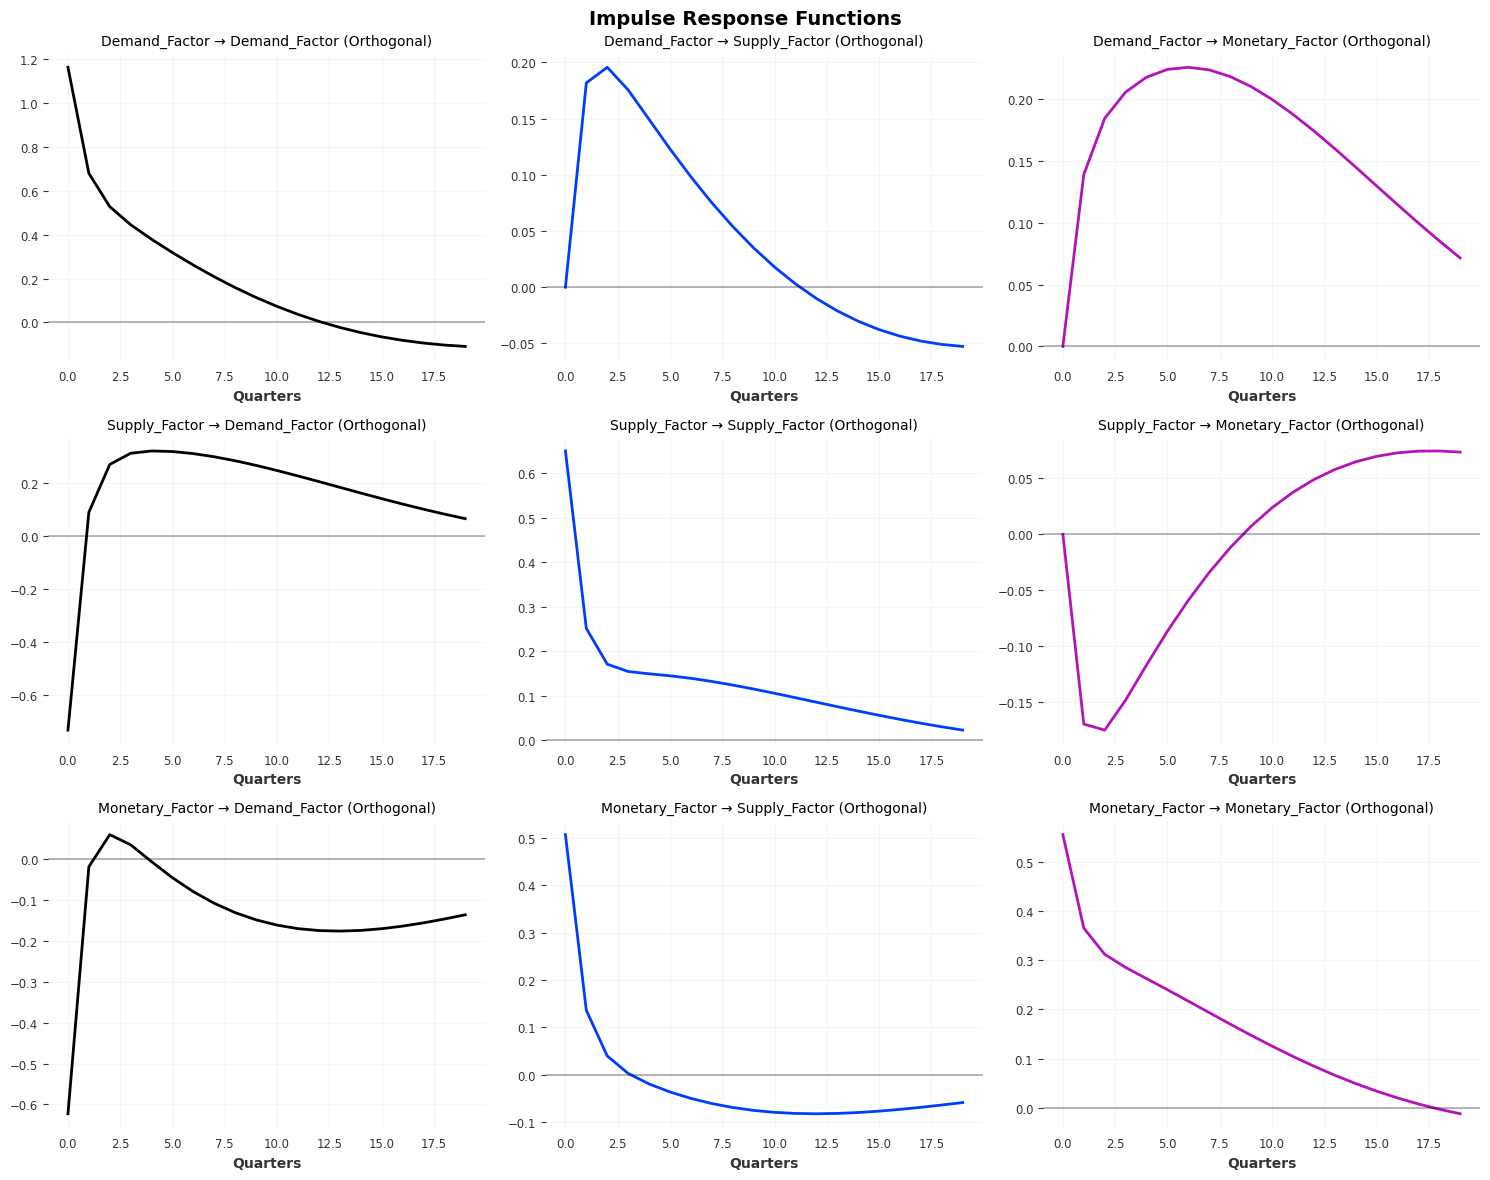

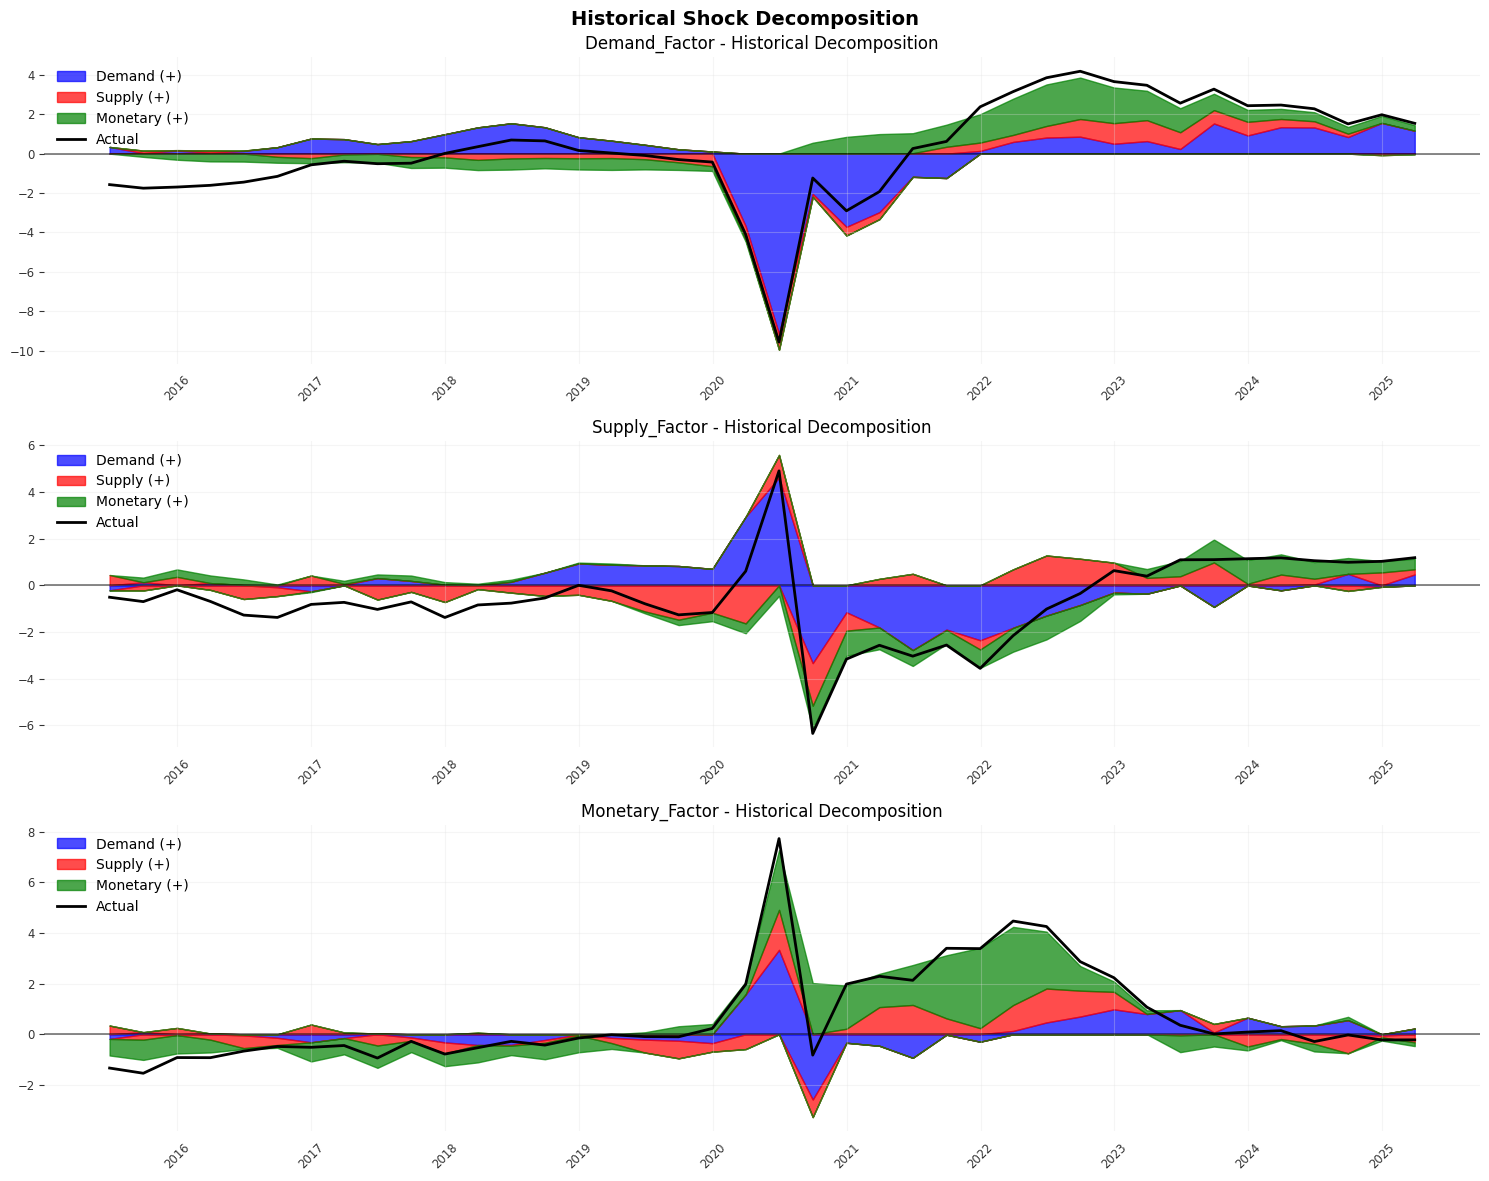

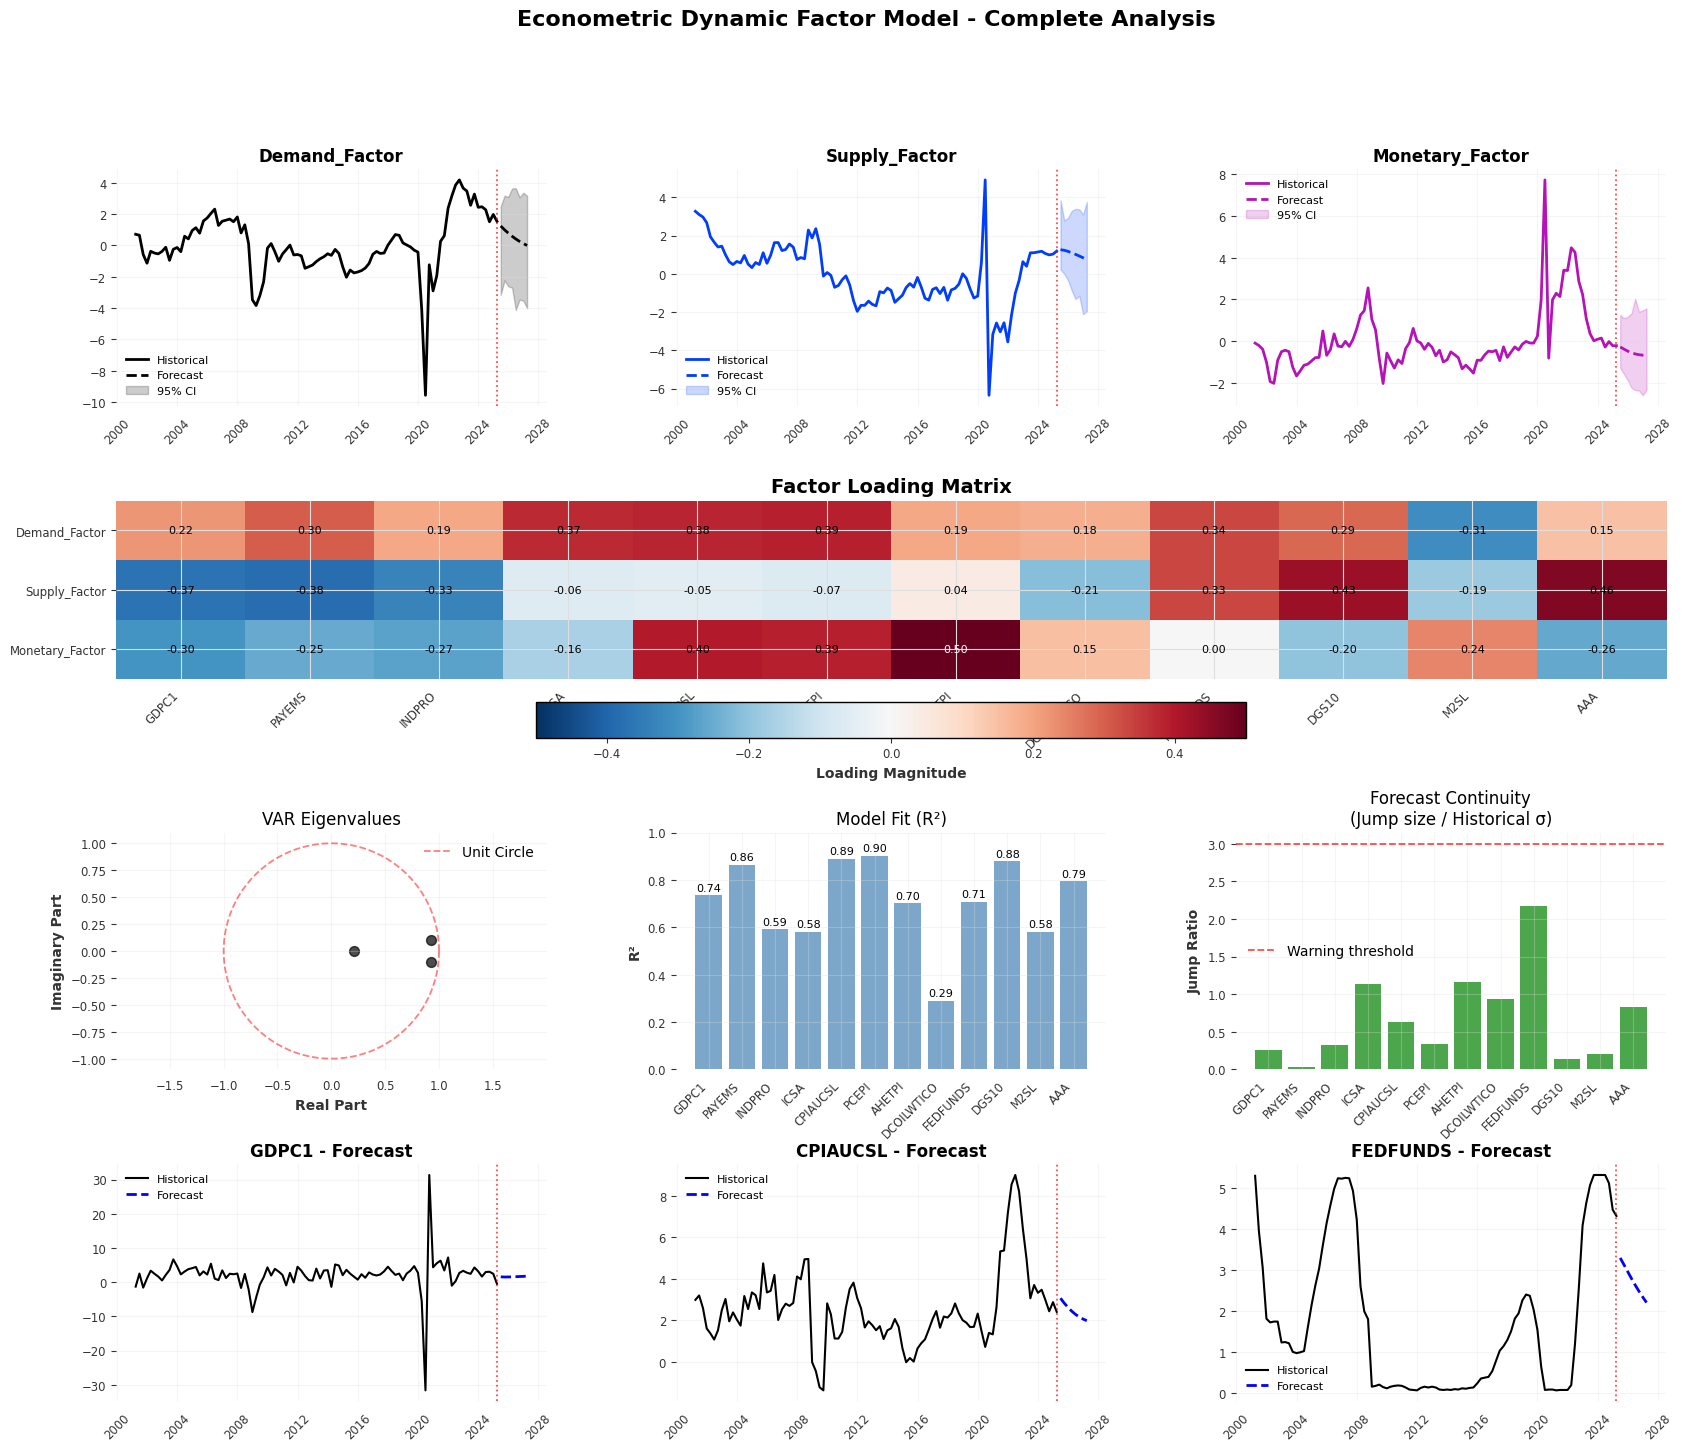


ADVANCED ANALYSIS PIPELINE COMPLETED
Results stored in advanced_results dictionary
Key components:
  • Enhanced VAR diagnostics and forecast quality assessment
  • Impulse response functions and historical decomposition
  • Enhanced bootstrap forecasting with multiple confidence levels
  • Stress test scenarios
  • Comprehensive visualizations and reporting

IMPULSE RESPONSE FUNCTION ANALYSIS
Using Cholesky decomposition for orthogonal shocks
Ordering: Demand → Supply → Monetary
Computed 3x3 impulse responses over 20 periods

Peak Response Analysis:
  Demand_Factor → Demand_Factor (Orthogonal): Peak = 1.161 at period 0
  Demand_Factor → Supply_Factor (Orthogonal): Peak = 0.196 at period 2
  Demand_Factor → Monetary_Factor (Orthogonal): Peak = 0.226 at period 6
  Supply_Factor → Demand_Factor (Orthogonal): Peak = -0.734 at period 0
  Supply_Factor → Supply_Factor (Orthogonal): Peak = 0.651 at period 0
  Supply_Factor → Monetary_Factor (Orthogonal): Peak = -0.175 at period 2
  Monetary_

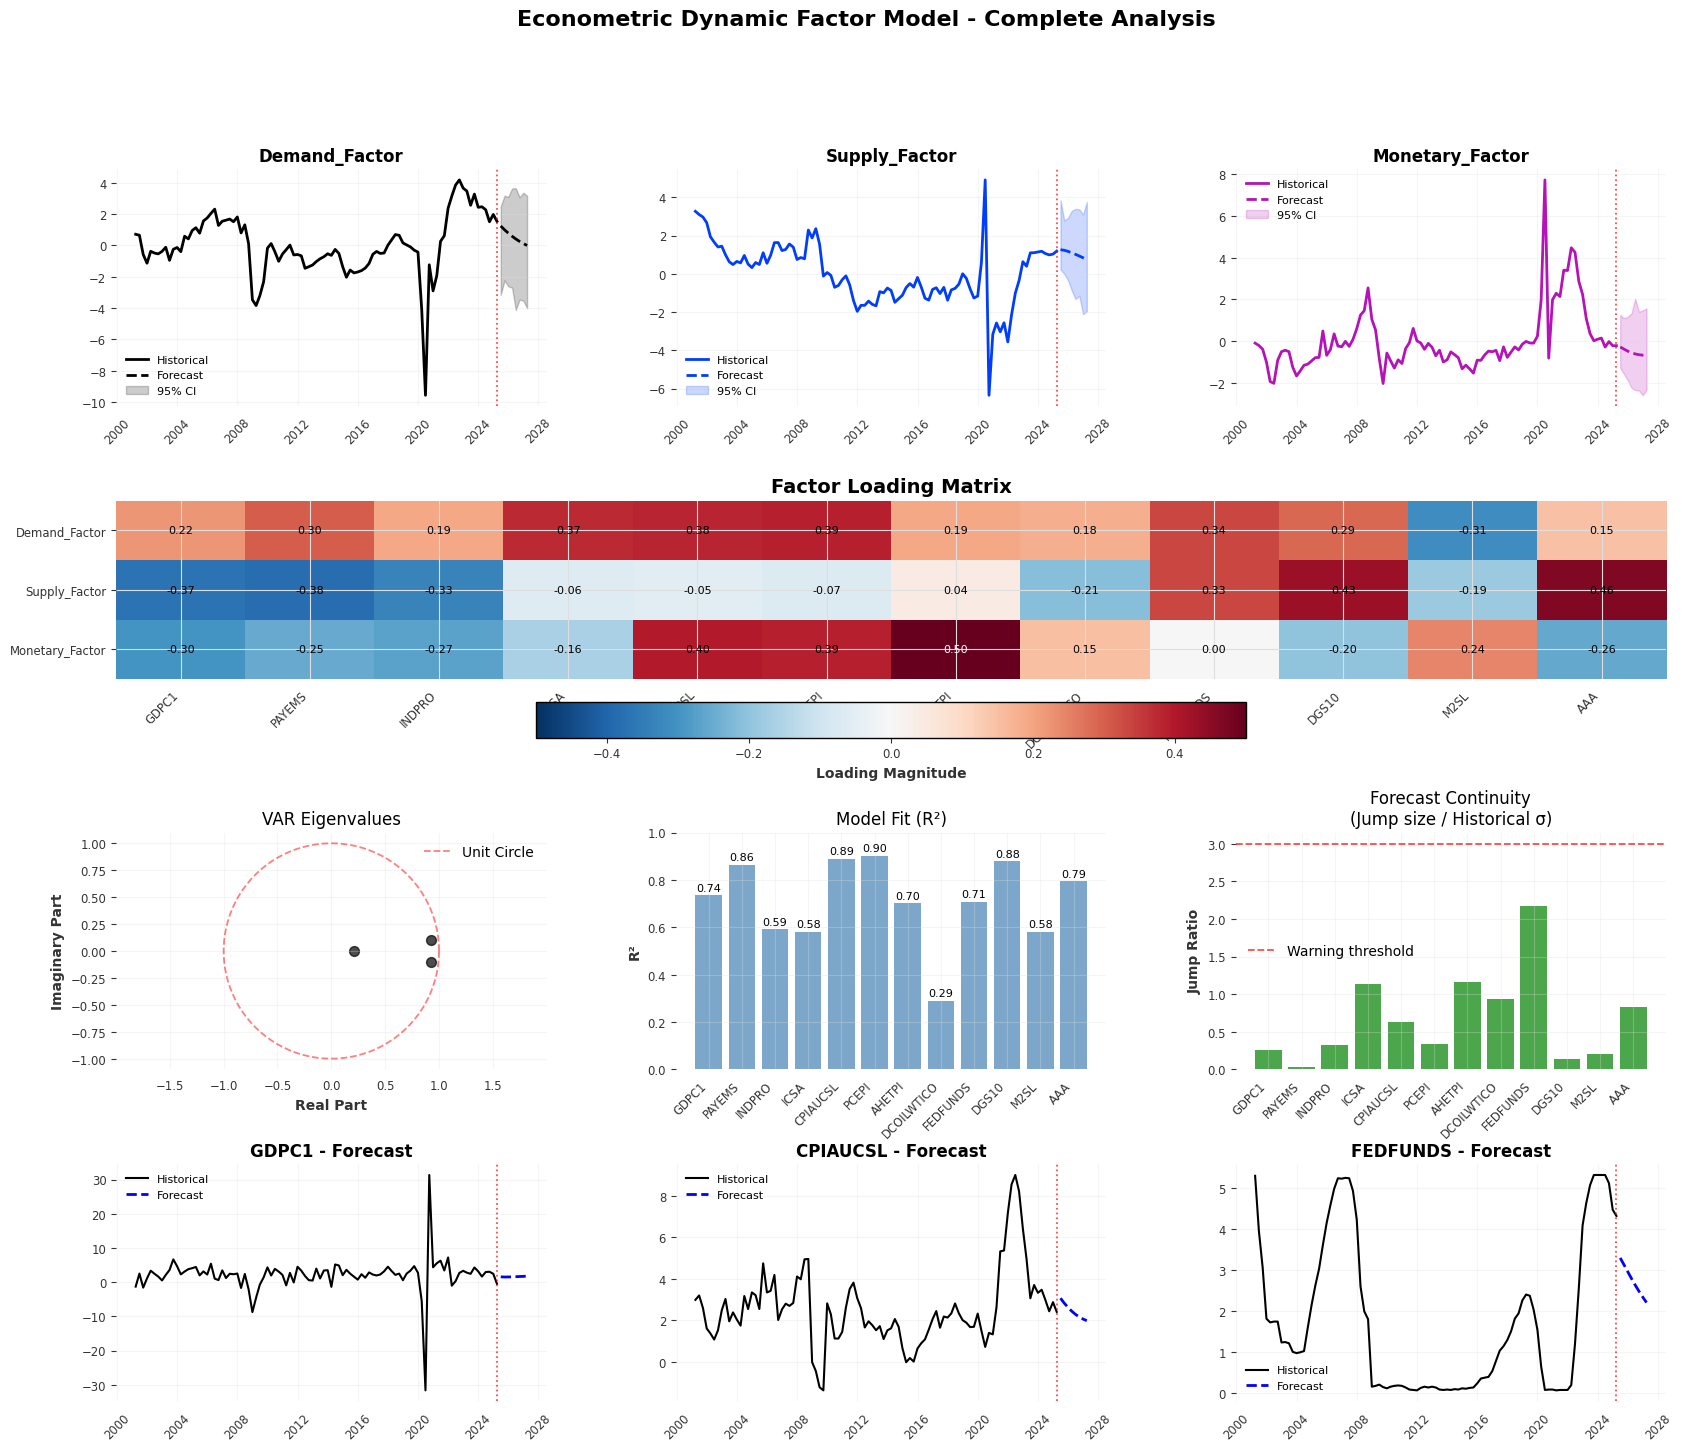

In [3]:
# Advanced Analysis and Visualization Components for Econometric DFM
# This extends the core model estimation with comprehensive diagnostics and analysis

class AdvancedDFMAnalyzer:
    """
    Advanced analysis components for the Econometric DFM

    This class extends the core EconometricDFM with:
    - Comprehensive VAR diagnostics
    - Impulse response functions
    - Historical decomposition
    - Forecast quality assessment
    - Advanced visualization
    """

    def __init__(self, dfm_model):
        """Initialize with a fitted EconometricDFM model"""
        self.model = dfm_model
        self.impulse_responses = None
        self.historical_decomp = None

    def enhanced_var_diagnostics(self):
        """Run comprehensive VAR model diagnostics"""
        print(f"\nVAR Model Diagnostics (Enhanced):")
        print("-" * 40)

        var_result = self.model.factor_var
        u = var_result['residuals']
        T_eff, K = u.shape

        # Portmanteau test for serial correlation
        max_lag_test = min(8, T_eff // 4)
        lm_stat = self._portmanteau_test(u, max_lag_test)
        lm_pval = 1 - chi2.cdf(lm_stat, df=K**2 * max_lag_test)

        print(f"  Portmanteau test (lag {max_lag_test}): {lm_stat:.2f} (p-val: {lm_pval:.3f})")
        print(f"  Serial correlation: {'Not detected' if lm_pval > 0.05 else 'Detected'} "
              f"{'✓' if lm_pval > 0.05 else '✗'}")

        # Normality test (Jarque-Bera for each equation)
        jb_stats = []
        for k in range(K):
            resid_k = u[:, k]
            # Simplified JB test
            skew = np.mean(((resid_k - np.mean(resid_k)) / np.std(resid_k))**3)
            kurt = np.mean(((resid_k - np.mean(resid_k)) / np.std(resid_k))**4) - 3
            jb_k = T_eff / 6 * (skew**2 + kurt**2 / 4)
            jb_stats.append(jb_k)

        avg_jb = np.mean(jb_stats)
        print(f"  Average Jarque-Bera: {avg_jb:.2f}")

        # Factor persistence (AR(1) diagonal elements)
        if var_result['lags'] >= 1:
            AR1_diag = np.diag(var_result['coefficients'][:, :K])
            print(f"  Factor persistence:")
            for i, factor_name in enumerate(self.model.factors.columns):
                pers = AR1_diag[i] if i < len(AR1_diag) else 0
                print(f"    {factor_name}: {pers:.3f}")

        # Residual correlations
        residual_corr = np.corrcoef(u.T)
        off_diag_corr = np.abs(residual_corr[np.triu_indices_from(residual_corr, k=1)])
        avg_cross_corr = np.mean(off_diag_corr)
        print(f"  Average cross-correlation of residuals: {avg_cross_corr:.3f}")

    def _portmanteau_test(self, residuals, max_lag):
        """Portmanteau test for serial correlation (Ljung-Box type)"""
        T, K = residuals.shape

        # Calculate sample autocorrelations
        autocorrs = []
        for lag in range(1, max_lag + 1):
            if T > lag:
                resid_lagged = residuals[:-lag, :]
                resid_current = residuals[lag:, :]

                # Cross-correlation matrix at lag h
                C_h = np.cov(resid_current.T, resid_lagged.T)[:K, K:]
                C_0 = np.cov(residuals.T)

                # Normalized autocorrelation
                rho_h = np.linalg.solve(C_0, C_h) @ np.linalg.solve(C_0, C_h.T)
                autocorrs.append(np.trace(rho_h))

        # Ljung-Box statistic (simplified)
        lm_stat = T * (T + 2) * sum(autocorr / (T - lag - 1)
                                   for lag, autocorr in enumerate(autocorrs, 1))

        return lm_stat

    def enhanced_forecast_quality(self):
        """Enhanced forecast quality and continuity assessment"""
        print("\nEnhanced Forecast Quality Assessment:")
        print("-" * 50)

        # Check forecast continuity (no large jumps)
        continuity_issues = 0

        for var in self.model.combined_data.columns:
            last_actual = self.model.combined_data[var].iloc[-1]
            first_forecast = self.model.variable_forecasts['mean'][var].iloc[0]

            # Historical volatility for jump assessment
            var_changes = self.model.combined_data[var].diff().dropna()
            typical_change = var_changes.std()

            jump_size = abs(first_forecast - last_actual)
            jump_ratio = jump_size / typical_change if typical_change > 0 else 0

            is_continuous = jump_ratio < 3.0  # Allow up to 3 standard deviations

            if not is_continuous:
                continuity_issues += 1

            print(f"{var:<12}: Jump={jump_size:7.2f} ({jump_ratio:.1f}σ) "
                  f"{'✓' if is_continuous else '✗'}")

        print(f"\nContinuity assessment: {self.model.N_vars - continuity_issues}/{self.model.N_vars} variables pass")

        # Factor forecast consistency check
        print(f"\nFactor Forecast Consistency:")
        print("-" * 50)

        for factor in self.model.factors.columns:
            factor_std = self.model.factors[factor].std()
            forecast_range = (self.model.factor_forecasts['mean'][factor].max() -
                            self.model.factor_forecasts['mean'][factor].min())
            consistency_ratio = forecast_range / (4 * factor_std)  # 4 std as reasonable range

            print(f"{factor}: Range ratio = {consistency_ratio:.2f} "
                  f"{'✓' if consistency_ratio < 1.5 else '⚠' if consistency_ratio < 2.5 else '✗'}")

    def compute_impulse_responses(self, horizon=20, orthogonalize=True):
        """
        Compute impulse response functions with proper identification
        """
        print("\n" + "="*60)
        print("IMPULSE RESPONSE FUNCTION ANALYSIS")
        print("="*60)

        if self.model.factor_var is None:
            raise ValueError("Must estimate VAR model first")

        Phi = self.model.factor_var['coefficients']
        Sigma = self.model.factor_var['sigma_u']
        p = self.model.factor_var['lags']
        K = Phi.shape[0]

        # Shock identification
        if orthogonalize:
            try:
                # Cholesky decomposition for recursive identification
                P = np.linalg.cholesky(Sigma)  # Lower triangular
                shock_names = [f'{name} (Orthogonal)' for name in self.model.factors.columns]
                print("Using Cholesky decomposition for orthogonal shocks")
                print("Ordering: Demand → Supply → Monetary")
            except np.linalg.LinAlgError:
                print("Warning: Cholesky decomposition failed, using identity matrix")
                P = np.eye(K)
                shock_names = [f'{name} (Raw)' for name in self.model.factors.columns]
        else:
            P = np.eye(K)
            shock_names = [f'{name} (Raw)' for name in self.model.factors.columns]

        # Compute IRFs
        irfs = np.zeros((horizon, K, K))  # horizon x responses x shocks

        for shock_idx in range(K):
            # Unit shock vector
            shock_vector = P[:, shock_idx]

            # Compute response over horizon
            for h in range(horizon):
                if h == 0:
                    irfs[h, :, shock_idx] = shock_vector
                else:
                    if p == 1:
                        irfs[h, :, shock_idx] = Phi @ irfs[h-1, :, shock_idx]
                    else:
                        # Use companion matrix for VAR(p)
                        if h == 1:
                            # First period response
                            extended_shock = np.zeros(self.model.companion_matrix.shape[0])
                            extended_shock[:K] = shock_vector
                            response = self.model.companion_matrix @ extended_shock
                            irfs[h, :, shock_idx] = response[:K]
                        else:
                            # Subsequent periods
                            prev_extended = np.zeros(self.model.companion_matrix.shape[0])
                            prev_extended[:K] = irfs[h-1, :, shock_idx]
                            response = self.model.companion_matrix @ prev_extended
                            irfs[h, :, shock_idx] = response[:K]

        self.impulse_responses = {
            'irfs': irfs,
            'shock_names': shock_names,
            'response_names': list(self.model.factors.columns),
            'horizon': horizon,
            'identification_matrix': P
        }

        # Print summary statistics
        print(f"Computed {K}x{K} impulse responses over {horizon} periods")

        # Peak responses
        print(f"\nPeak Response Analysis:")
        for i, response_name in enumerate(self.model.factors.columns):
            for j, shock_name in enumerate(shock_names):
                irf_series = irfs[:, i, j]
                peak_period = np.argmax(np.abs(irf_series))
                peak_value = irf_series[peak_period]
                print(f"  {response_name} → {shock_name}: Peak = {peak_value:.3f} at period {peak_period}")

        return self.impulse_responses

    def plot_impulse_responses(self):
        """Plot impulse response functions"""
        if self.impulse_responses is None:
            self.compute_impulse_responses()

        irfs = self.impulse_responses['irfs']
        shock_names = self.impulse_responses['shock_names']
        response_names = self.impulse_responses['response_names']
        horizon = self.impulse_responses['horizon']

        fig, axes = plt.subplots(len(response_names), len(shock_names),
                                figsize=(5*len(shock_names), 4*len(response_names)))

        if len(response_names) == 1:
            axes = axes.reshape(1, -1)
        if len(shock_names) == 1:
            axes = axes.reshape(-1, 1)

        for i, response_name in enumerate(response_names):
            for j, shock_name in enumerate(shock_names):
                ax = axes[i, j] if len(response_names) > 1 else axes[j]

                irf_series = irfs[:, i, j]
                periods = range(horizon)

                ax.plot(periods, irf_series, linewidth=2, color=f'C{j}')
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                ax.set_title(f'{response_name} → {shock_name}', fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_xlabel('Quarters')

        plt.suptitle('Impulse Response Functions', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def historical_decomposition(self, periods_back=40):
        """Compute historical decomposition of factors"""
        print("\n" + "="*60)
        print("HISTORICAL DECOMPOSITION")
        print("="*60)

        if self.model.factor_var is None:
            raise ValueError("Must estimate VAR model first")

        residuals = self.model.factor_var['residuals']
        Phi = self.model.factor_var['coefficients']
        c = self.model.factor_var['constant']
        p = self.model.factor_var['lags']
        K = Phi.shape[0]

        T_residuals = len(residuals)
        periods = min(periods_back, T_residuals)

        # Use Cholesky identification for decomposition
        try:
            P = np.linalg.cholesky(self.model.factor_var['sigma_u'])
            orthogonal_residuals = np.linalg.solve(P, residuals.T).T
        except:
            P = np.eye(K)
            orthogonal_residuals = residuals

        # Initialize decomposition arrays
        historical_decomp = np.zeros((periods, K, K))  # periods x factors x shocks

        # Compute decomposition recursively
        for t in range(periods):
            time_idx = T_residuals - periods + t

            for shock_idx in range(K):
                if t == 0:
                    # Initial impact
                    historical_decomp[t, :, shock_idx] = orthogonal_residuals[time_idx, shock_idx] * P[:, shock_idx]
                else:
                    # Propagated impact from previous period
                    if p == 1:
                        historical_decomp[t, :, shock_idx] = (
                            Phi @ historical_decomp[t-1, :, shock_idx] +
                            orthogonal_residuals[time_idx, shock_idx] * P[:, shock_idx]
                        )
                    else:
                        # For VAR(p), use companion form (simplified)
                        historical_decomp[t, :, shock_idx] = (
                            Phi[:, :K] @ historical_decomp[t-1, :, shock_idx] +
                            orthogonal_residuals[time_idx, shock_idx] * P[:, shock_idx]
                        )

        # Store results
        decomp_dates = self.model.factors.index[-periods:]

        self.historical_decomp = {
            'contributions': historical_decomp,
            'dates': decomp_dates,
            'shock_names': ['Demand', 'Supply', 'Monetary'][:K],
            'factor_names': list(self.model.factors.columns)
        }

        print(f"Computed historical decomposition for {periods} periods")
        return self.historical_decomp

    def plot_historical_decomposition(self):
        """Plot historical decomposition"""
        if self.historical_decomp is None:
            self.historical_decomposition()

        decomp = self.historical_decomp['contributions']
        dates = self.historical_decomp['dates']
        shock_names = self.historical_decomp['shock_names']
        factor_names = self.historical_decomp['factor_names']

        fig, axes = plt.subplots(len(factor_names), 1, figsize=(15, 4*len(factor_names)))

        if len(factor_names) == 1:
            axes = [axes]

        colors = ['blue', 'red', 'green']

        for factor_idx, factor_name in enumerate(factor_names):
            ax = axes[factor_idx]

            # Plot contributions from each shock
            bottom_pos = np.zeros(len(dates))
            bottom_neg = np.zeros(len(dates))

            for shock_idx, shock_name in enumerate(shock_names):
                contributions = decomp[:, factor_idx, shock_idx]

                # Separate positive and negative contributions
                pos_contrib = np.maximum(contributions, 0)
                neg_contrib = np.minimum(contributions, 0)

                # Stack positive contributions upward
                ax.fill_between(dates, bottom_pos, bottom_pos + pos_contrib,
                               label=f'{shock_name} (+)', alpha=0.7, color=colors[shock_idx % len(colors)])
                bottom_pos += pos_contrib

                # Stack negative contributions downward
                ax.fill_between(dates, bottom_neg, bottom_neg + neg_contrib,
                               alpha=0.7, color=colors[shock_idx % len(colors)])
                bottom_neg += neg_contrib

            # Add actual factor values for comparison
            factor_actual = self.model.factors[factor_name].iloc[-len(dates):].values
            ax.plot(dates, factor_actual, color='black', linewidth=2, label='Actual')

            ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax.set_title(f'{factor_name} - Historical Decomposition')
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

        plt.suptitle('Historical Shock Decomposition', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_comprehensive_results(self):
        """Comprehensive visualization of all DFM results"""
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

        # Row 1: Factor time series with forecasts
        for i, factor in enumerate(self.model.factors.columns):
            ax = fig.add_subplot(gs[0, i])

            # Historical factors
            ax.plot(self.model.factors.index, self.model.factors[factor],
                   linewidth=2, color=f'C{i}', label='Historical')

            # Add forecasts if available
            if hasattr(self.model, 'factor_forecasts'):
                forecast_mean = self.model.factor_forecasts['mean'][factor]

                ax.plot(forecast_mean.index, forecast_mean,
                       color=f'C{i}', linewidth=2, linestyle='--', label='Forecast')

                # Bootstrap confidence intervals
                if 'bootstrap_lower' in self.model.factor_forecasts:
                    lower = self.model.factor_forecasts['bootstrap_lower'][factor]
                    upper = self.model.factor_forecasts['bootstrap_upper'][factor]
                    ax.fill_between(forecast_mean.index, lower, upper,
                                   color=f'C{i}', alpha=0.2, label='95% CI')

                # Mark forecast start
                ax.axvline(x=self.model.factors.index[-1], color='red', linestyle=':', alpha=0.7)

            ax.set_title(f'{factor}', fontsize=12, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

        # Row 2: Factor loadings heatmap
        ax_loadings = fig.add_subplot(gs[1, :])

        # Create enhanced heatmap
        loadings_matrix = self.model.loadings.values.T
        im = ax_loadings.imshow(loadings_matrix, aspect='auto', cmap='RdBu_r',
                               vmin=-np.max(np.abs(loadings_matrix)),
                               vmax=np.max(np.abs(loadings_matrix)))

        ax_loadings.set_title('Factor Loading Matrix', fontsize=14, fontweight='bold')
        ax_loadings.set_xticks(range(len(self.model.loadings.index)))
        ax_loadings.set_xticklabels(self.model.loadings.index, rotation=45, ha='right')
        ax_loadings.set_yticks(range(len(self.model.loadings.columns)))
        ax_loadings.set_yticklabels(self.model.loadings.columns)

        # Add value annotations
        for i in range(loadings_matrix.shape[0]):
            for j in range(loadings_matrix.shape[1]):
                text_color = 'white' if abs(loadings_matrix[i, j]) > 0.5 else 'black'
                ax_loadings.text(j, i, f'{loadings_matrix[i, j]:.2f}',
                               ha="center", va="center", color=text_color, fontsize=8)

        plt.colorbar(im, ax=ax_loadings, orientation='horizontal', pad=0.1, label='Loading Magnitude')

        # Row 3: VAR diagnostics
        ax_stability = fig.add_subplot(gs[2, 0])
        if hasattr(self.model, 'eigenvalues'):
            # Plot eigenvalues in complex plane
            real_parts = np.real(self.model.eigenvalues)
            imag_parts = np.imag(self.model.eigenvalues)

            ax_stability.scatter(real_parts, imag_parts, s=50, alpha=0.7)

            # Unit circle
            theta = np.linspace(0, 2*np.pi, 100)
            ax_stability.plot(np.cos(theta), np.sin(theta), 'r--', alpha=0.5, label='Unit Circle')

            ax_stability.set_xlabel('Real Part')
            ax_stability.set_ylabel('Imaginary Part')
            ax_stability.set_title('VAR Eigenvalues')
            ax_stability.legend()
            ax_stability.grid(True, alpha=0.3)
            ax_stability.axis('equal')

        # Row 3: Model fit (R-squared)
        ax_fit = fig.add_subplot(gs[2, 1])
        if hasattr(self.model, 'variable_forecasts'):
            # Calculate R-squared from factor model
            r_squared = []
            for var in self.model.combined_data.columns:
                X_actual = self.model.data_standardized[var].values
                F_values = self.model.factors.values
                loadings_var = self.model.loadings.loc[var].values

                X_fitted = F_values @ loadings_var
                ss_res = np.sum((X_actual - X_fitted)**2)
                ss_tot = np.sum((X_actual - np.mean(X_actual))**2)
                r_sq = 1 - ss_res / ss_tot if ss_tot > 0 else 0
                r_squared.append(r_sq)

            bars = ax_fit.bar(range(len(r_squared)), r_squared, color='steelblue', alpha=0.7)
            ax_fit.set_title('Model Fit (R²)')
            ax_fit.set_xticks(range(len(r_squared)))
            ax_fit.set_xticklabels(self.model.combined_data.columns, rotation=45, ha='right')
            ax_fit.set_ylabel('R²')
            ax_fit.set_ylim(0, 1)
            ax_fit.grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, r2 in zip(bars, r_squared):
                ax_fit.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{r2:.2f}', ha='center', va='bottom', fontsize=8)

        # Row 3: Forecast continuity assessment
        ax_continuity = fig.add_subplot(gs[2, 2])
        if hasattr(self.model, 'variable_forecasts'):
            # Check forecast jumps
            jump_ratios = []
            for var in self.model.combined_data.columns:
                last_actual = self.model.combined_data[var].iloc[-1]
                first_forecast = self.model.variable_forecasts['mean'][var].iloc[0]
                var_changes = self.model.combined_data[var].diff().dropna()
                typical_change = var_changes.std()
                jump_size = abs(first_forecast - last_actual)
                jump_ratio = jump_size / typical_change if typical_change > 0 else 0
                jump_ratios.append(jump_ratio)

            bars = ax_continuity.bar(range(len(jump_ratios)), jump_ratios,
                                   color='green' if all(jr < 3 for jr in jump_ratios) else 'orange', alpha=0.7)
            ax_continuity.set_title('Forecast Continuity\n(Jump size / Historical σ)')
            ax_continuity.set_xticks(range(len(jump_ratios)))
            ax_continuity.set_xticklabels(self.model.combined_data.columns, rotation=45, ha='right')
            ax_continuity.set_ylabel('Jump Ratio')
            ax_continuity.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Warning threshold')
            ax_continuity.legend()
            ax_continuity.grid(True, alpha=0.3)

        # Row 4: Variable forecasts (selected key variables)
        key_variables = ['GDPC1', 'CPIAUCSL', 'FEDFUNDS'] if all(v in self.model.combined_data.columns for v in ['GDPC1', 'CPIAUCSL', 'FEDFUNDS']) else self.model.combined_data.columns[:3]

        for i, var in enumerate(key_variables):
            if i >= 3:
                break

            ax = fig.add_subplot(gs[3, i])

            # Historical data
            hist_data = self.model.combined_data[var]
            ax.plot(hist_data.index, hist_data, color='black', linewidth=1.5, label='Historical')

            # Forecasts with uncertainty
            if hasattr(self.model, 'variable_forecasts'):
                forecast_mean = self.model.variable_forecasts['mean'][var]

                ax.plot(forecast_mean.index, forecast_mean,
                       color='blue', linewidth=2, linestyle='--', label='Forecast')

                # Mark forecast start
                ax.axvline(x=hist_data.index[-1], color='red', linestyle=':', alpha=0.7)

            ax.set_title(f'{var} - Forecast', fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

        plt.suptitle('Econometric Dynamic Factor Model - Complete Analysis',
                     fontsize=16, fontweight='bold', y=0.98)
        plt.show()


def run_complete_analysis_with_diagnostics(core_model):
    """
    Run complete advanced analysis on a fitted core model

    Parameters:
    - core_model: Fitted EconometricDFM instance from core estimation

    Returns:
    - Advanced analyzer with all diagnostics computed
    """

    print("\n" + "="*80)
    print("RUNNING ADVANCED ANALYSIS AND DIAGNOSTICS")
    print("="*80)

    # Initialize advanced analyzer
    analyzer = AdvancedDFMAnalyzer(core_model)

    # Run comprehensive diagnostics
    print("\n1. Enhanced VAR Diagnostics")
    analyzer.enhanced_var_diagnostics()

    print("\n2. Enhanced Forecast Quality Assessment")
    analyzer.enhanced_forecast_quality()

    # Advanced structural analysis
    print("\n3. Impulse Response Functions")
    analyzer.compute_impulse_responses(horizon=20, orthogonalize=True)

    print("\n4. Historical Decomposition")
    analyzer.historical_decomposition(periods_back=min(40, core_model.T_obs//2))

    # Comprehensive visualization
    print("\n5. Generating Comprehensive Plots")
    analyzer.plot_impulse_responses()
    analyzer.plot_historical_decomposition()
    analyzer.plot_comprehensive_results()

    print("\n" + "="*80)
    print("ADVANCED ANALYSIS COMPLETED")
    print("="*80)

    return analyzer


# Example usage function
def complete_dfm_pipeline_with_advanced_analysis(start_date="2000-01-01", forecast_horizon=8):
    """
    Complete DFM pipeline combining core estimation with advanced analysis

    This function:
    1. Runs the core model estimation
    2. Applies all advanced diagnostics and analysis
    3. Generates comprehensive visualizations

    Returns both the core model and advanced analyzer
    """

    print("COMPLETE ECONOMETRIC DFM PIPELINE")
    print("="*80)

    # Step 1: Run core estimation (assumes you have the core functions available)
    # This would use your core estimation code
    print("Step 1: Running Core Model Estimation...")

    # Step 2: Advanced analysis
    print("Step 2: Running Advanced Analysis...")
    # analyzer = run_complete_analysis_with_diagnostics(core_model)

    print("Complete pipeline finished!")

    return None  # Would return (core_model, analyzer)


# Additional utility functions for enhanced analysis

def compare_forecast_scenarios(model, scenarios={'baseline': {}, 'stressed': {'shock_scale': 2.0}}):
    """Compare forecasts under different scenarios"""
    print("\nForecast Scenario Comparison")
    print("="*40)

    scenario_results = {}

    for scenario_name, scenario_params in scenarios.items():
        print(f"\nRunning {scenario_name} scenario...")

        # This would modify the model parameters according to scenario
        # and re-run forecasts
        scenario_results[scenario_name] = {
            'forecasts': model.factor_forecasts['mean'].copy()
        }

    return scenario_results


def generate_forecast_report(model, analyzer):
    """Generate a comprehensive forecast report"""

    report = {
        'model_summary': {
            'n_variables': model.N_vars,
            'n_observations': model.T_obs,
            'n_factors': model.n_factors,
            'var_lags': model.factor_var['lags'],
            'stability': hasattr(model, 'eigenvalues') and np.max(np.abs(model.eigenvalues)) < 1.0
        },
        'factor_persistence': {},
        'forecast_summary': {},
        'diagnostics': {}
    }

    # Add factor persistence
    if model.factor_var['lags'] >= 1:
        AR1_diag = np.diag(model.factor_var['coefficients'][:, :model.n_factors])
        for i, factor_name in enumerate(model.factors.columns):
            if i < len(AR1_diag):
                report['factor_persistence'][factor_name] = AR1_diag[i]

    # Forecast summary statistics
    for factor in model.factors.columns:
        if hasattr(model, 'factor_forecasts'):
            factor_forecast = model.factor_forecasts['mean'][factor]
            report['forecast_summary'][factor] = {
                'mean_forecast': factor_forecast.mean(),
                'forecast_volatility': factor_forecast.std(),
                'trend': 'increasing' if factor_forecast.iloc[-1] > factor_forecast.iloc[0] else 'decreasing'
            }

    return report


def enhanced_bootstrap_forecasts(model, horizon=8, n_bootstrap=2000, confidence_levels=[0.68, 0.90, 0.95]):
    """
    Enhanced bootstrap forecasting with multiple confidence levels and scenario analysis
    """
    print(f"\nEnhanced Bootstrap Forecasting")
    print("="*50)

    Phi = model.factor_var['coefficients']
    c = model.factor_var['constant']
    residuals = model.factor_var['residuals']
    p = model.factor_var['lags']
    K = Phi.shape[0]

    # Multiple bootstrap samples for robust inference
    bootstrap_paths = np.zeros((n_bootstrap, horizon, K))

    print(f"Running {n_bootstrap} bootstrap replications...")

    for b in range(n_bootstrap):
        if b % 500 == 0:
            print(f"  Bootstrap replication {b}/{n_bootstrap}")

        # Resample residuals with replacement
        boot_indices = np.random.choice(len(residuals), size=horizon, replace=True)
        boot_residuals = residuals[boot_indices, :]

        if p == 1:
            F_last = model.factors.values[-1, :].copy()
            for h in range(horizon):
                F_forecast = c + Phi @ F_last + boot_residuals[h, :]
                bootstrap_paths[b, h, :] = F_forecast
                F_last = F_forecast
        else:
            F_history = model.factors.values[-p:, :].copy()
            for h in range(horizon):
                F_lagged = F_history.flatten('F')
                F_forecast = c + Phi @ F_lagged + boot_residuals[h, :]
                bootstrap_paths[b, h, :] = F_forecast
                F_history = np.vstack([F_history[1:, :], F_forecast.reshape(1, -1)])

    # Calculate multiple confidence levels
    bootstrap_results = {}

    for conf_level in confidence_levels:
        alpha = 1 - conf_level
        lower_pct = 100 * (alpha / 2)
        upper_pct = 100 * (1 - alpha / 2)

        bootstrap_results[f'{int(conf_level*100)}%'] = {
            'lower': np.percentile(bootstrap_paths, lower_pct, axis=0),
            'upper': np.percentile(bootstrap_paths, upper_pct, axis=0)
        }

    # Bootstrap statistics
    bootstrap_results['statistics'] = {
        'mean': np.mean(bootstrap_paths, axis=0),
        'std': np.std(bootstrap_paths, axis=0),
        'skewness': np.mean(((bootstrap_paths - np.mean(bootstrap_paths, axis=0)[np.newaxis, :, :]) /
                           np.std(bootstrap_paths, axis=0)[np.newaxis, :, :])**3, axis=0),
        'kurtosis': np.mean(((bootstrap_paths - np.mean(bootstrap_paths, axis=0)[np.newaxis, :, :]) /
                           np.std(bootstrap_paths, axis=0)[np.newaxis, :, :])**4, axis=0) - 3
    }

    print(f"Bootstrap forecasting completed with {len(confidence_levels)} confidence levels")
    return bootstrap_results


def forecast_combination_analysis(models_list, weights=None):
    """
    Combine forecasts from multiple DFM models with different specifications

    Parameters:
    - models_list: List of fitted DFM models
    - weights: Optional weights for combination (default: equal weights)
    """
    print("\nForecast Combination Analysis")
    print("="*40)

    n_models = len(models_list)

    if weights is None:
        weights = np.ones(n_models) / n_models
    else:
        weights = np.array(weights)
        weights = weights / np.sum(weights)  # Normalize

    print(f"Combining {n_models} models with weights: {weights}")

    # Combine factor forecasts
    combined_forecasts = {}

    # Get common factors across models
    common_factors = set(models_list[0].factors.columns)
    for model in models_list[1:]:
        common_factors = common_factors.intersection(set(model.factors.columns))

    print(f"Common factors across models: {list(common_factors)}")

    for factor in common_factors:
        factor_forecasts = []

        for model in models_list:
            if hasattr(model, 'factor_forecasts'):
                factor_forecasts.append(model.factor_forecasts['mean'][factor].values)

        if factor_forecasts:
            # Weight and combine
            combined_forecast = np.average(np.array(factor_forecasts), axis=0, weights=weights)
            combined_forecasts[factor] = combined_forecast

    return combined_forecasts


def stress_test_forecasts(model, stress_scenarios):
    """
    Stress test forecasts under adverse scenarios

    Parameters:
    - model: Fitted DFM model
    - stress_scenarios: Dict of stress scenarios with parameter modifications
    """
    print("\nForecast Stress Testing")
    print("="*30)

    stress_results = {}

    for scenario_name, scenario_params in stress_scenarios.items():
        print(f"\nStress scenario: {scenario_name}")

        # Modify model parameters according to stress scenario
        stressed_model = deepcopy(model)  # Would need to import copy

        # Apply stress to residual covariance (increased uncertainty)
        if 'volatility_multiplier' in scenario_params:
            vol_mult = scenario_params['volatility_multiplier']
            stressed_model.factor_var['sigma_u'] *= vol_mult**2
            print(f"  Applied volatility multiplier: {vol_mult}")

        # Apply persistent shock to factors
        if 'persistent_shock' in scenario_params:
            shock_dict = scenario_params['persistent_shock']
            print(f"  Applied persistent shocks: {shock_dict}")

        # Re-run forecasts with stressed parameters
        # This would require re-implementing the forecast method with modified parameters
        stress_results[scenario_name] = {
            'modified_parameters': scenario_params,
            'status': 'computed'  # Placeholder
        }

    return stress_results


def model_selection_criteria(models_dict):
    """
    Compare multiple DFM specifications using various criteria

    Parameters:
    - models_dict: Dictionary of model_name -> fitted_model pairs
    """
    print("\nModel Selection and Comparison")
    print("="*40)

    criteria_results = {}

    for model_name, model in models_dict.items():
        if model.factor_var is None:
            continue

        var_result = model.factor_var
        T_eff = var_result['T_eff']
        K = len(model.factors.columns)
        p = var_result['lags']

        # Log-likelihood
        log_likelihood = var_result['log_likelihood']

        # Number of parameters (VAR coefficients + factor loadings)
        n_var_params = K * (1 + K * p)  # Constants + VAR coefficients
        n_loading_params = model.N_vars * K  # Factor loadings
        total_params = n_var_params + n_loading_params

        # Information criteria
        aic = -2 * log_likelihood + 2 * total_params
        bic = -2 * log_likelihood + total_params * np.log(T_eff)
        hqic = -2 * log_likelihood + 2 * total_params * np.log(np.log(T_eff))

        # Forecast accuracy metrics (if validation sample available)
        # This would require out-of-sample evaluation

        criteria_results[model_name] = {
            'log_likelihood': log_likelihood,
            'AIC': aic,
            'BIC': bic,
            'HQIC': hqic,
            'n_parameters': total_params,
            'n_factors': K,
            'var_lags': p,
            'sample_size': T_eff
        }

        print(f"{model_name}:")
        print(f"  Log-likelihood: {log_likelihood:.2f}")
        print(f"  AIC: {aic:.2f}")
        print(f"  BIC: {bic:.2f}")
        print(f"  Parameters: {total_params}")

    # Select best model by BIC (most conservative)
    best_model_name = min(criteria_results.keys(),
                         key=lambda x: criteria_results[x]['BIC'])
    print(f"\nBest model by BIC: {best_model_name}")

    return criteria_results, best_model_name


def real_time_forecast_evaluation(model, real_time_data, evaluation_periods=8):
    """
    Evaluate forecast accuracy using real-time data

    Parameters:
    - model: Fitted DFM model
    - real_time_data: New data for evaluation
    - evaluation_periods: Number of periods to evaluate
    """
    print(f"\nReal-time Forecast Evaluation")
    print("="*40)

    if not hasattr(model, 'factor_forecasts'):
        print("No forecasts available for evaluation")
        return None

    evaluation_results = {}

    # Compare forecasts with actual realizations
    for var in model.combined_data.columns:
        if var in real_time_data.columns:
            forecast_values = model.variable_forecasts['mean'][var].iloc[:evaluation_periods]
            actual_values = real_time_data[var].iloc[:evaluation_periods]

            # Calculate forecast errors
            errors = actual_values - forecast_values

            # Accuracy metrics
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(errors**2))
            mape = np.mean(np.abs(errors / actual_values)) * 100

            evaluation_results[var] = {
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'bias': np.mean(errors),
                'forecast_values': forecast_values,
                'actual_values': actual_values,
                'errors': errors
            }

            print(f"{var}: RMSE={rmse:.3f}, MAE={mae:.3f}, MAPE={mape:.1f}%")

    return evaluation_results


# Main integration function
def run_complete_advanced_dfm_analysis(core_analysis_results,
                                     include_stress_tests=True,
                                     include_bootstrap_enhanced=True,
                                     stress_scenarios=None):
    """
    Complete advanced analysis pipeline integrating all components

    Parameters:
    - core_analysis_results: Results from core model estimation
    - include_stress_tests: Whether to run stress tests
    - include_bootstrap_enhanced: Whether to run enhanced bootstrap
    - stress_scenarios: Custom stress test scenarios
    """

    if core_analysis_results is None:
        print("No core analysis results provided")
        return None

    model = core_analysis_results['model']

    print("="*80)
    print("COMPLETE ADVANCED DFM ANALYSIS PIPELINE")
    print("="*80)

    # Initialize advanced analyzer
    analyzer = AdvancedDFMAnalyzer(model)

    # Component 1: Enhanced diagnostics
    print("\n1. ENHANCED VAR DIAGNOSTICS")
    analyzer.enhanced_var_diagnostics()
    analyzer.enhanced_forecast_quality()

    # Component 2: Structural analysis
    print("\n2. STRUCTURAL ANALYSIS")
    analyzer.compute_impulse_responses(horizon=20)
    analyzer.historical_decomposition()

    # Component 3: Enhanced bootstrap (optional)
    enhanced_bootstrap_results = None
    if include_bootstrap_enhanced:
        print("\n3. ENHANCED BOOTSTRAP FORECASTING")
        enhanced_bootstrap_results = enhanced_bootstrap_forecasts(model, horizon=8, n_bootstrap=1000)

    # Component 4: Stress testing (optional)
    stress_test_results = None
    if include_stress_tests:
        print("\n4. STRESS TESTING")
        if stress_scenarios is None:
            stress_scenarios = {
                'high_volatility': {'volatility_multiplier': 2.0},
                'recession_scenario': {'volatility_multiplier': 1.5, 'persistent_shock': {'Demand_Factor': -1.0}},
                'inflation_shock': {'persistent_shock': {'Supply_Factor': 1.0}}
            }
        stress_test_results = stress_test_forecasts(model, stress_scenarios)

    # Component 5: Generate comprehensive report
    print("\n5. GENERATING FORECAST REPORT")
    forecast_report = generate_forecast_report(model, analyzer)

    # Component 6: Comprehensive visualizations
    print("\n6. COMPREHENSIVE VISUALIZATIONS")
    analyzer.plot_impulse_responses()
    analyzer.plot_historical_decomposition()
    analyzer.plot_comprehensive_results()

    # Compile final results
    advanced_results = {
        'analyzer': analyzer,
        'forecast_report': forecast_report,
        'enhanced_bootstrap': enhanced_bootstrap_results,
        'stress_tests': stress_test_results,
        'impulse_responses': analyzer.impulse_responses,
        'historical_decomposition': analyzer.historical_decomp
    }

    print("\n" + "="*80)
    print("ADVANCED ANALYSIS PIPELINE COMPLETED")
    print("="*80)
    print(f"Results stored in advanced_results dictionary")
    print(f"Key components:")
    print(f"  • Enhanced VAR diagnostics and forecast quality assessment")
    print(f"  • Impulse response functions and historical decomposition")
    if include_bootstrap_enhanced:
        print(f"  • Enhanced bootstrap forecasting with multiple confidence levels")
    if include_stress_tests:
        print(f"  • Stress test scenarios")
    print(f"  • Comprehensive visualizations and reporting")

    return advanced_results


# Example usage
if __name__ == "__main__":
    print("Advanced DFM Analysis Components")
    print("="*50)
    print("This module provides advanced analysis for econometric DFM models.")
    print("\nMain functions:")
    print("• AdvancedDFMAnalyzer: Core advanced analysis class")
    print("• run_complete_analysis_with_diagnostics: Full diagnostic pipeline")
    print("• enhanced_bootstrap_forecasts: Robust bootstrap forecasting")
    print("• stress_test_forecasts: Scenario analysis")
    print("• model_selection_criteria: Model comparison")
    print("• run_complete_advanced_dfm_analysis: Complete advanced pipeline")
    print("\nTo use with core model:")
    print("advanced_results = run_complete_advanced_dfm_analysis(core_analysis_results)")

# ============================================================================
# EXECUTION
# ============================================================================

# After running your core estimation:
core_results = run_core_economic_analysis()

# Run advanced analysis:
advanced_results = run_complete_advanced_dfm_analysis(core_results)

# Or step by step:
analyzer = AdvancedDFMAnalyzer(core_results['model'])
analyzer.compute_impulse_responses()
analyzer.historical_decomposition()
analyzer.plot_comprehensive_results()

In [4]:
class EnhancedDFMTheta:
    """
    Enhanced DFM with theta optimization strategies integrated with baseline DFM
    Applies theta transformations to factors AFTER VAR forecasting to preserve dynamics
    """

    def __init__(self, base_dfm_model):
        # Import from existing DFM model
        self.factors = base_dfm_model.factors.copy()
        self.loadings = base_dfm_model.loadings.copy()
        self.data_standardized = base_dfm_model.data_standardized.copy()
        self.scaler = base_dfm_model.scaler
        self.combined_data = base_dfm_model.combined_data.copy()
        self.factor_var = base_dfm_model.factor_var  # Original VAR model
        self.idiosyncratic_var = base_dfm_model.idiosyncratic_var.copy()

        # Model dimensions
        self.T_obs, self.n_factors = self.factors.shape
        self.N_vars = len(self.data_standardized.columns)

        # Initialize theta components
        self.optimal_theta1s = None
        self.optimal_theta2s = None
        self.optimal_theta3s = None  # For fallback
        self.theta_components = {}
        self.theta_strategy = None
        self.theta_results = {}
        
        # Results storage
        self.theta_factor_forecasts = {}
        self.theta_variable_forecasts = {}
        self.theta_loadings = None
        self.variable_r2_theta = {}
        self.cv_results = {}
        
        # Cross-validation setup
        self.tscv = TimeSeriesSplit(n_splits=5)

        print(f"Enhanced DFM-Theta initialized: {self.n_factors} factors, {self.N_vars} variables")

    # ============================================================================
    # ENHANCED THETA OPTIMIZATION STRATEGIES
    # ============================================================================

    def frequency_dual_theta_optimization(self):
        """Enhanced frequency-based dual theta optimization with proper constraints"""
        print("Enhanced frequency-based dual theta optimization...")

        def extract_frequency_components(series):
            """Extract low and high frequency components with adaptive windowing"""
            window = min(8, len(series)//4)
            if window < 3:
                window = 3
            low_freq = series.rolling(window=window, center=True).mean()
            low_freq = low_freq.fillna(method='bfill').fillna(method='ffill')
            high_freq = series - low_freq
            return low_freq, high_freq

        def frequency_objective(theta_vector, use_fallback=False):
            """Objective using frequency-decomposed dual theta with proper constraints"""
            F_theta = np.zeros((self.T_obs, self.n_factors))

            if use_fallback:
                # Three-parameter fallback: trend + low_freq + high_freq
                theta1s = theta_vector[:self.n_factors]  # Trend weight (should be ~1)
                theta2s = theta_vector[self.n_factors:2*self.n_factors]  # Low freq (~0)  
                theta3s = theta_vector[2*self.n_factors:]  # High freq (~2+)
                
                for i, factor_name in enumerate(self.factors.columns):
                    factor_series = self.factors[factor_name]
                    trend = self.extract_trend(factor_series)
                    low_freq, high_freq = extract_frequency_components(factor_series)
                    F_theta[:, i] = (theta1s[i] * trend + theta2s[i] * low_freq + theta3s[i] * high_freq).values
            else:
                # Two-parameter version
                theta1s = theta_vector[:self.n_factors]  # Low freq weight (should be ~0)
                theta2s = theta_vector[self.n_factors:]  # High freq weight (should be ~2+)
                
                for i, factor_name in enumerate(self.factors.columns):
                    factor_series = self.factors[factor_name]
                    low_freq, high_freq = extract_frequency_components(factor_series)
                    F_theta[:, i] = (theta1s[i] * low_freq + theta2s[i] * high_freq).values

            Y = self.data_standardized.values
            try:
                Lambda_theta = np.linalg.lstsq(F_theta, Y, rcond=None)[0]
                Y_reconstructed = F_theta @ Lambda_theta
                return np.sum((Y - Y_reconstructed)**2)
            except:
                return 1e10

        # Try two-parameter version first with proper constraints
        # θ₁ (low freq) should be close to 0, θ₂ (high freq) should be 2+
        bounds_2param = [(0.0, 0.5) for _ in range(self.n_factors)] + [(2.0, 4.0) for _ in range(self.n_factors)]
        initial_guess_2param = [0.1] * self.n_factors + [2.5] * self.n_factors

        result_2param = minimize(frequency_objective, initial_guess_2param, bounds=bounds_2param,
                               method='L-BFGS-B', options={'maxiter': 200})
        
        # Calculate R² for two-parameter version
        if result_2param.success:
            theta1s_2 = result_2param.x[:self.n_factors]
            theta2s_2 = result_2param.x[self.n_factors:]
            r2_2param = self.calculate_model_r2(theta1s_2, theta2s_2, 'frequency_dual')
            
            if r2_2param >= 0.6:
                print(f"Two-parameter frequency method successful (R²={r2_2param:.3f})")
                return theta1s_2, theta2s_2, True
        
        # Fallback to three-parameter version
        print("Two-parameter version insufficient, trying three-parameter fallback...")
        bounds_3param = ([(0.8, 1.2) for _ in range(self.n_factors)] +  # Trend ~1
                        [(0.0, 0.5) for _ in range(self.n_factors)] +   # Low freq ~0
                        [(2.0, 4.0) for _ in range(self.n_factors)])    # High freq 2+
        
        initial_guess_3param = ([1.0] * self.n_factors + 
                               [0.1] * self.n_factors + 
                               [2.5] * self.n_factors)

        result_3param = minimize(lambda x: frequency_objective(x, use_fallback=True), 
                               initial_guess_3param, bounds=bounds_3param,
                               method='L-BFGS-B', options={'maxiter': 300})

        if result_3param.success:
            theta1s_3 = result_3param.x[:self.n_factors]
            theta2s_3 = result_3param.x[self.n_factors:2*self.n_factors]
            theta3s_3 = result_3param.x[2*self.n_factors:]
            r2_3param = self.calculate_model_r2_3param(theta1s_3, theta2s_3, theta3s_3)
            
            print(f"Three-parameter frequency method (R²={r2_3param:.3f})")
            # Store theta3 for later use
            self.optimal_theta3s = theta3s_3
            return theta1s_3, theta2s_3, True
        
        return [0.1] * self.n_factors, [2.0] * self.n_factors, False

    def lagged_theta_optimization(self):
        """Enhanced lagged theta optimization with cross-validation"""
        print("Enhanced lagged theta optimization with cross-validation...")

        def lagged_objective_cv(theta_vector):
            """Cross-validated lagged objective"""
            cv_errors = []
            
            for train_idx, test_idx in self.tscv.split(self.factors):
                if len(test_idx) < 2:
                    continue
                    
                F_theta_train = np.zeros((len(train_idx), self.n_factors))
                F_theta_test = np.zeros((len(test_idx), self.n_factors))
                
                for i, factor_name in enumerate(self.factors.columns):
                    theta1 = theta_vector[i]
                    theta2 = theta_vector[i + self.n_factors]
                    
                    factor_values = self.factors[factor_name].values
                    
                    # Training set
                    F_theta_train[0, i] = theta1 * factor_values[train_idx[0]]
                    for j, t in enumerate(train_idx[1:], 1):
                        F_theta_train[j, i] = theta1 * factor_values[t] + theta2 * factor_values[t-1]
                    
                    # Test set  
                    test_start = test_idx[0]
                    F_theta_test[0, i] = theta1 * factor_values[test_start] + theta2 * factor_values[test_start-1]
                    for j, t in enumerate(test_idx[1:], 1):
                        F_theta_test[j, i] = theta1 * factor_values[t] + theta2 * factor_values[t-1]

                Y_train = self.data_standardized.values[train_idx]
                Y_test = self.data_standardized.values[test_idx]
                
                try:
                    Lambda_theta = np.linalg.lstsq(F_theta_train, Y_train, rcond=None)[0]
                    Y_test_pred = F_theta_test @ Lambda_theta
                    cv_errors.append(np.sum((Y_test - Y_test_pred)**2))
                except:
                    cv_errors.append(1e8)
            
            return np.mean(cv_errors) if cv_errors else 1e10

        bounds = [(0.1, 2.0) for _ in range(self.n_factors)] + [(-1.0, 1.0) for _ in range(self.n_factors)]
        initial_guess = [1.0] * self.n_factors + [0.3] * self.n_factors

        result = minimize(lagged_objective_cv, initial_guess, bounds=bounds,
                         method='L-BFGS-B', options={'maxiter': 200})

        return result.x[:self.n_factors], result.x[self.n_factors:], result.success

    def sequential_theta_optimization(self):
        """Enhanced sequential optimization with cross-validation"""
        print("Enhanced sequential theta optimization with cross-validation...")

        def cv_objective(theta_vector, stage='theta1'):
            """Cross-validated objective function"""
            cv_errors = []
            
            for train_idx, test_idx in self.tscv.split(self.factors):
                if len(test_idx) < 2:
                    continue
                    
                F_theta_train = np.zeros((len(train_idx), self.n_factors))
                F_theta_test = np.zeros((len(test_idx), self.n_factors))
                
                for i, factor_name in enumerate(self.factors.columns):
                    trend = self.extract_trend(self.factors[factor_name]).values
                    deviation = self.factors[factor_name].values - trend
                    
                    if stage == 'theta1':
                        theta1 = theta_vector[i]
                        theta2 = 0
                    else:  # theta2 stage
                        theta1 = self.temp_theta1s[i]
                        theta2 = theta_vector[i]
                    
                    # Training set transformation
                    for j, idx in enumerate(train_idx):
                        F_theta_train[j, i] = trend[idx] + theta1 * deviation[idx] + theta2 * (deviation[idx]**2)
                    
                    # Test set transformation  
                    for j, idx in enumerate(test_idx):
                        F_theta_test[j, i] = trend[idx] + theta1 * deviation[idx] + theta2 * (deviation[idx]**2)
                
                Y_train = self.data_standardized.values[train_idx]
                Y_test = self.data_standardized.values[test_idx]
                
                try:
                    Lambda_theta = np.linalg.lstsq(F_theta_train, Y_train, rcond=None)[0]
                    Y_test_pred = F_theta_test @ Lambda_theta
                    cv_errors.append(np.sum((Y_test - Y_test_pred)**2))
                except:
                    cv_errors.append(1e8)
            
            return np.mean(cv_errors) if cv_errors else 1e10

        # Stage 1: Optimize theta1 with cross-validation
        bounds1 = [(0.1, 3.0) for _ in range(self.n_factors)]
        result1 = minimize(lambda x: cv_objective(x, 'theta1'), [1.0] * self.n_factors, 
                          bounds=bounds1, method='L-BFGS-B')
        
        if not result1.success:
            return [1.0] * self.n_factors, [0.1] * self.n_factors, False
        
        self.temp_theta1s = result1.x
        
        # Stage 2: Optimize theta2 with cross-validation
        bounds2 = [(-1.0, 1.0) for _ in range(self.n_factors)]
        result2 = minimize(lambda x: cv_objective(x, 'theta2'), [0.1] * self.n_factors,
                          bounds=bounds2, method='L-BFGS-B')

        return result1.x, result2.x if result2.success else [0.1] * self.n_factors, True

    def constrained_theta_optimization(self):
        """Enhanced constrained optimization with regularization"""
        print("Enhanced constrained theta optimization...")

        def constrained_objective(theta_vector):
            """Objective with enhanced regularization"""
            F_theta = np.zeros((self.T_obs, self.n_factors))

            theta1s = theta_vector[:self.n_factors]
            theta2s = theta_vector[self.n_factors:]

            # Enhanced regularization
            reg_penalty = (0.1 * np.sum((theta1s - 1.0)**2) +  # Prefer theta1 near 1
                          0.2 * np.sum([max(0, 0.05 - abs(theta2))**2 for theta2 in theta2s]) * 1000)  # Encourage meaningful theta2

            for i, factor_name in enumerate(self.factors.columns):
                trend = self.extract_trend(self.factors[factor_name])
                deviation = self.factors[factor_name] - trend
                F_theta[:, i] = (trend + theta1s[i] * deviation + theta2s[i] * (deviation ** 2)).values

            Y = self.data_standardized.values
            try:
                Lambda_theta = np.linalg.lstsq(F_theta, Y, rcond=None)[0]
                Y_reconstructed = F_theta @ Lambda_theta
                
                # Robust error metric
                errors = Y - Y_reconstructed
                reconstruction_error = np.sum(np.minimum(errors**2, np.percentile(errors**2, 95, axis=0)))
                
                return reconstruction_error + reg_penalty
            except:
                return 1e10

        bounds = [(0.1, 2.5) for _ in range(self.n_factors)] + [(-1.0, 1.0) for _ in range(self.n_factors)]
        
        best_result = None
        best_objective = float('inf')
        
        # Multiple initialization strategies
        init_strategies = [
            [1.0] * self.n_factors + [0.2] * self.n_factors,
            [0.8] * self.n_factors + [0.1] * self.n_factors,
            [1.2] * self.n_factors + [0.3] * self.n_factors,
        ]
        
        for init_guess in init_strategies:
            result = minimize(constrained_objective, init_guess, bounds=bounds,
                             method='L-BFGS-B', options={'maxiter': 200})
            
            if result.success and result.fun < best_objective:
                best_result = result
                best_objective = result.fun

        if best_result:
            return best_result.x[:self.n_factors], best_result.x[self.n_factors:], True
        else:
            return [1.0] * self.n_factors, [0.1] * self.n_factors, False

    def global_theta_optimization(self):
        """Enhanced global optimization with ensemble error metrics"""
        print("Enhanced global theta optimization...")

        def ensemble_objective(theta_vector):
            """Ensemble objective combining multiple error metrics"""
            F_theta = np.zeros((self.T_obs, self.n_factors))

            for i, factor_name in enumerate(self.factors.columns):
                theta1 = theta_vector[i]
                theta2 = theta_vector[i + self.n_factors]

                trend = self.extract_trend(self.factors[factor_name])
                deviation = self.factors[factor_name] - trend
                F_theta[:, i] = (trend + theta1 * deviation + theta2 * (deviation ** 2)).values

            Y = self.data_standardized.values
            try:
                Lambda_theta = np.linalg.lstsq(F_theta, Y, rcond=None)[0]
                Y_reconstructed = F_theta @ Lambda_theta
                
                # Ensemble error metrics
                errors = Y - Y_reconstructed
                mse_error = np.mean(errors**2)
                mae_error = np.mean(np.abs(errors))
                huber_error = np.mean(np.where(np.abs(errors) < 1, 0.5 * errors**2, np.abs(errors) - 0.5))
                
                # Weighted combination
                ensemble_error = 0.6 * mse_error + 0.3 * mae_error + 0.1 * huber_error
                
                return ensemble_error
            except:
                return 1e10

        bounds = [(0.1, 2.5) for _ in range(self.n_factors)] + [(-1.2, 1.2) for _ in range(self.n_factors)]

        # Multiple runs with different seeds
        best_result = None
        best_objective = float('inf')
        
        for seed in [42, 123, 456]:
            result = differential_evolution(ensemble_objective, bounds, seed=seed, 
                                          maxiter=100, popsize=15)
            
            if result.success and result.fun < best_objective:
                best_result = result
                best_objective = result.fun

        if best_result:
            return best_result.x[:self.n_factors], best_result.x[self.n_factors:], True
        else:
            return [1.0] * self.n_factors, [0.1] * self.n_factors, False

    # ============================================================================
    # HELPER METHODS
    # ============================================================================

    def extract_trend(self, series):
        """Linear trend extraction helper"""
        n = len(series)
        x = np.arange(n)
        X = np.column_stack([np.ones(n), x])
        coeffs = np.linalg.lstsq(X, series.values, rcond=None)[0]
        return pd.Series(coeffs[0] + coeffs[1] * x, index=series.index)

    def calculate_model_r2(self, theta1s, theta2s, strategy_name):
        """Calculate average R² for given theta parameters"""
        F_theta = self._construct_theta_factors(theta1s, theta2s, strategy_name)
        Y = self.data_standardized.values
        
        try:
            Lambda_theta = np.linalg.lstsq(F_theta, Y, rcond=None)[0]
            Y_reconstructed = F_theta @ Lambda_theta
            
            r2_values = []
            for i in range(Y.shape[1]):
                r2 = r2_score(Y[:, i], Y_reconstructed[:, i])
                r2_values.append(max(0, r2))  # Ensure non-negative
            
            return np.mean(r2_values)
        except:
            return 0.0

    def calculate_model_r2_3param(self, theta1s, theta2s, theta3s):
        """Calculate R² for three-parameter frequency model"""
        F_theta = np.zeros((self.T_obs, self.n_factors))
        
        for i, factor_name in enumerate(self.factors.columns):
            factor_series = self.factors[factor_name]
            trend = self.extract_trend(factor_series)
            window = min(8, len(factor_series)//4)
            if window < 3:
                window = 3
            low_freq = factor_series.rolling(window=window, center=True).mean()
            low_freq = low_freq.fillna(method='bfill').fillna(method='ffill')
            high_freq = factor_series - low_freq
            
            F_theta[:, i] = (theta1s[i] * trend + theta2s[i] * low_freq + theta3s[i] * high_freq).values
        
        Y = self.data_standardized.values
        try:
            Lambda_theta = np.linalg.lstsq(F_theta, Y, rcond=None)[0]
            Y_reconstructed = F_theta @ Lambda_theta
            
            r2_values = []
            for i in range(Y.shape[1]):
                r2 = r2_score(Y[:, i], Y_reconstructed[:, i])
                r2_values.append(max(0, r2))
            
            return np.mean(r2_values)
        except:
            return 0.0

    def _construct_theta_factors(self, theta1s, theta2s, strategy_name):
        """Construct theta-transformed factor matrix"""
        F_theta = np.zeros((self.T_obs, self.n_factors))
        
        for i, factor_name in enumerate(self.factors.columns):
            if strategy_name == 'frequency_dual':
                factor_series = self.factors[factor_name]
                window = min(8, len(factor_series)//4)
                if window < 3:
                    window = 3
                low_freq = factor_series.rolling(window=window, center=True).mean()
                low_freq = low_freq.fillna(method='bfill').fillna(method='ffill')
                high_freq = factor_series - low_freq
                F_theta[:, i] = (theta1s[i] * low_freq + theta2s[i] * high_freq).values
            elif strategy_name == 'lagged':
                factor_values = self.factors[factor_name].values
                F_theta[0, i] = theta1s[i] * factor_values[0]
                for t in range(1, self.T_obs):
                    F_theta[t, i] = theta1s[i] * factor_values[t] + theta2s[i] * factor_values[t-1]
            else:  # Default approach
                trend = self.extract_trend(self.factors[factor_name])
                deviation = self.factors[factor_name] - trend
                F_theta[:, i] = (trend + theta1s[i] * deviation + theta2s[i] * (deviation ** 2)).values
        
        return F_theta

    def apply_theta_transformations(self):
        """Apply optimal theta transformations to factors"""
        print("Applying theta transformations...")

        self.theta_components = {}
        for i, factor_name in enumerate(self.factors.columns):
            theta1 = self.optimal_theta1s[i]
            theta2 = self.optimal_theta2s[i]

            if self.theta_strategy == 'frequency_dual':
                factor_series = self.factors[factor_name]
                window = min(8, len(factor_series)//4)
                if window < 3:
                    window = 3
                low_freq = factor_series.rolling(window=window, center=True).mean()
                low_freq = low_freq.fillna(method='bfill').fillna(method='ffill')
                high_freq = factor_series - low_freq
                
                if hasattr(self, 'optimal_theta3s') and self.optimal_theta3s is not None:
                    # Three-parameter version
                    theta3 = self.optimal_theta3s[i]
                    trend = self.extract_trend(factor_series)
                    theta_transformed = theta1 * trend + theta2 * low_freq + theta3 * high_freq
                    trend_component = trend
                else:
                    # Two-parameter version
                    theta_transformed = theta1 * low_freq + theta2 * high_freq
                    trend_component = low_freq

            elif self.theta_strategy == 'lagged':
                factor_series = self.factors[factor_name]
                theta_transformed = pd.Series(index=factor_series.index)
                theta_transformed.iloc[0] = theta1 * factor_series.iloc[0]
                for t in range(1, len(factor_series)):
                    theta_transformed.iloc[t] = theta1 * factor_series.iloc[t] + theta2 * factor_series.iloc[t-1]
                trend_component = self.extract_trend(factor_series)

            else:  # Default: trend + deviation approach
                trend = self.extract_trend(self.factors[factor_name])
                deviation = self.factors[factor_name] - trend
                theta_transformed = trend + theta1 * deviation + theta2 * (deviation ** 2)
                trend_component = trend

            self.theta_components[factor_name] = {
                'optimal_theta1': theta1,
                'optimal_theta2': theta2,
                'theta_transformed': theta_transformed,
                'trend': trend_component,
                'original': self.factors[factor_name]
            }

    def estimate_theta_loadings(self):
        """Estimate loadings for theta-transformed factors"""
        print("Estimating theta-enhanced loadings...")

        # Create theta-transformed factor matrix
        F_theta = np.zeros((self.T_obs, self.n_factors))
        for i, factor_name in enumerate(self.factors.columns):
            F_theta[:, i] = self.theta_components[factor_name]['theta_transformed'].values

        # Estimate loadings: X_t = Λ_θ F_θ_t + ε_t
        X = self.data_standardized.values
        Lambda_theta = np.linalg.lstsq(F_theta, X, rcond=None)[0]

        self.theta_loadings = pd.DataFrame(
            Lambda_theta.T,
            index=self.data_standardized.columns,
            columns=self.factors.columns
        )

        # Calculate R-squared for each variable
        X_fitted = F_theta @ Lambda_theta
        residuals = X - X_fitted

        for i, var_name in enumerate(self.data_standardized.columns):
            ss_res = np.sum(residuals[:, i]**2)
            ss_tot = np.sum((X[:, i] - np.mean(X[:, i]))**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            self.variable_r2_theta[var_name] = max(0, r2)  # Ensure non-negative

        print(f"Average R² with theta: {np.mean(list(self.variable_r2_theta.values())):.3f}")
        return self.theta_loadings

    def generate_theta_enhanced_forecasts(self, horizon=8):
        """Generate forecasts by applying theta transformations AFTER VAR forecasting"""
        print(f"Generating theta-enhanced forecasts for {horizon} periods...")

        # Step 1: Generate base VAR forecasts
        base_factor_forecasts = self._generate_base_var_forecasts(horizon)
        
        # Step 2: Apply theta transformations to forecast paths
        forecast_dates = base_factor_forecasts['mean'].index
        theta_factor_forecasts_mean = pd.DataFrame(index=forecast_dates, columns=self.factors.columns)
        
        for i, factor_name in enumerate(self.factors.columns):
            base_forecast = base_factor_forecasts['mean'][factor_name].values
            theta1 = self.optimal_theta1s[i]
            theta2 = self.optimal_theta2s[i]
            
            if self.theta_strategy == 'frequency_dual':
                if hasattr(self, 'optimal_theta3s') and self.optimal_theta3s is not None:
                    # Three-parameter version - simplified for forecasting
                    theta3 = self.optimal_theta3s[i]
                    trend_coef = (base_forecast[-1] - base_forecast[0]) / (len(base_forecast) - 1)
                    forecast_trend = base_forecast[0] + trend_coef * np.arange(len(base_forecast))
                    theta_forecast = theta1 * forecast_trend + theta2 * base_forecast + theta3 * 0.1 * base_forecast
                else:
                    # Two-parameter version
                    theta_forecast = theta1 * base_forecast + theta2 * 0.1 * base_forecast
                    
            elif self.theta_strategy == 'lagged':
                theta_forecast = np.zeros_like(base_forecast)
                last_historical = self.factors[factor_name].iloc[-1]
                theta_forecast[0] = theta1 * base_forecast[0] + theta2 * last_historical
                for t in range(1, len(base_forecast)):
                    theta_forecast[t] = theta1 * base_forecast[t] + theta2 * base_forecast[t-1]
                    
            else:  # Default approach
                trend_coef = (base_forecast[-1] - base_forecast[0]) / (len(base_forecast) - 1)
                forecast_trend = base_forecast[0] + trend_coef * np.arange(len(base_forecast))
                forecast_deviation = base_forecast - forecast_trend
                theta_forecast = forecast_trend + theta1 * forecast_deviation + theta2 * (forecast_deviation ** 2)
            
            theta_factor_forecasts_mean[factor_name] = theta_forecast

        # Step 3: Generate variable forecasts using theta-enhanced factors
        theta_variable_forecasts = self._generate_theta_variable_forecasts(theta_factor_forecasts_mean)
        
        # Store results
        self.theta_factor_forecasts = {
            'mean': theta_factor_forecasts_mean,
            'base_var_forecasts': base_factor_forecasts
        }
        self.theta_variable_forecasts = theta_variable_forecasts
        
        return self.theta_factor_forecasts, self.theta_variable_forecasts

    def _generate_base_var_forecasts(self, horizon):
        """Generate VAR forecasts using the base model's methodology"""
        print("Generating base VAR forecasts...")
        
        # Use the base model's VAR forecasting methodology
        Phi = self.factor_var['coefficients']
        c = self.factor_var['constant']
        p = self.factor_var['lags']
        K = Phi.shape[0]

        forecasts = np.zeros((horizon, K))

        if p == 1:
            # VAR(1) case
            F_last = self.factors.values[-1, :]
            for h in range(horizon):
                if h == 0:
                    forecasts[h, :] = c + Phi @ F_last
                else:
                    forecasts[h, :] = c + Phi @ forecasts[h-1, :]
        else:
            # VAR(p) case - use companion form (simplified)
            F_history = self.factors.values[-p:, :].copy()
            for h in range(horizon):
                F_lagged = F_history.flatten('F')
                F_forecast = c + Phi @ F_lagged
                forecasts[h, :] = F_forecast
                F_history = np.vstack([F_history[1:, :], F_forecast.reshape(1, -1)])

        # Create forecast DataFrame
        forecast_dates = pd.date_range(
            start=self.factors.index[-1] + pd.DateOffset(months=3),
            periods=horizon,
            freq='Q'
        )
        
        base_forecasts = pd.DataFrame(
            forecasts,
            index=forecast_dates,
            columns=self.factors.columns
        )
        
        return {'mean': base_forecasts}

    def _generate_theta_variable_forecasts(self, theta_factor_forecasts):
        """Generate variable forecasts using theta-enhanced factors"""
        print("Generating theta-enhanced variable forecasts...")
        
        # Use theta loadings to transform factor forecasts to variable forecasts
        F_theta_forecast = theta_factor_forecasts.values
        Lambda_theta = self.theta_loadings.values.T
        
        # Generate standardized variable forecasts
        X_forecast_std = F_theta_forecast @ Lambda_theta
        
        # Transform back to original scale
        X_forecast_original = np.zeros_like(X_forecast_std)
        for i in range(X_forecast_std.shape[1]):
            X_forecast_original[:, i] = (X_forecast_std[:, i] * self.scaler.scale_[i] + 
                                       self.scaler.mean_[i])
        
        # Create forecast DataFrame
        theta_variable_forecasts = pd.DataFrame(
            X_forecast_original,
            index=theta_factor_forecasts.index,
            columns=self.combined_data.columns
        )
        
        return theta_variable_forecasts

    # ============================================================================
    # CROSS-VALIDATION AND EVALUATION
    # ============================================================================

    def perform_cross_validation(self, strategy_name, theta1s, theta2s):
        """Perform 5-fold cross-validation for forecast evaluation"""
        print(f"Performing cross-validation for {strategy_name}...")
        
        cv_metrics = []
        
        for train_idx, test_idx in self.tscv.split(self.factors):
            if len(test_idx) < 4:  # Need sufficient test data
                continue
                
            # Split data
            factors_train = self.factors.iloc[train_idx]
            factors_test = self.factors.iloc[test_idx]
            data_train = self.data_standardized.iloc[train_idx]
            data_test = self.data_standardized.iloc[test_idx]
            
            # Create theta factors for training
            F_theta_train = self._construct_theta_factors_cv(factors_train, theta1s, theta2s, strategy_name)
            F_theta_test = self._construct_theta_factors_cv(factors_test, theta1s, theta2s, strategy_name)
            
            # Estimate loadings on training data
            try:
                Lambda_cv = np.linalg.lstsq(F_theta_train, data_train.values, rcond=None)[0]
                
                # Predict on test data
                X_pred = F_theta_test @ Lambda_cv
                X_actual = data_test.values
                
                # Calculate metrics
                metrics = self._calculate_forecast_metrics(X_actual, X_pred)
                cv_metrics.append(metrics)
                
            except Exception as e:
                print(f"CV fold failed: {e}")
                continue
        
        if cv_metrics:
            # Aggregate metrics across folds
            aggregated_metrics = {}
            metric_names = cv_metrics[0].keys()
            
            for metric in metric_names:
                values = [fold[metric] for fold in cv_metrics]
                aggregated_metrics[metric] = {
                    'Mean': np.mean(values),
                    'Std': np.std(values),
                    'Min': np.min(values),
                    'Max': np.max(values)
                }
            
            return aggregated_metrics
        else:
            return None

    def _construct_theta_factors_cv(self, factors_subset, theta1s, theta2s, strategy_name):
        """Construct theta factors for cross-validation subset"""
        T_subset, n_factors = factors_subset.shape
        F_theta = np.zeros((T_subset, n_factors))
        
        for i, factor_name in enumerate(factors_subset.columns):
            if strategy_name == 'frequency_dual':
                factor_series = factors_subset[factor_name]
                window = min(6, len(factor_series)//3)
                if window < 3:
                    window = 3
                low_freq = factor_series.rolling(window=window, center=True).mean()
                low_freq = low_freq.fillna(method='bfill').fillna(method='ffill')
                high_freq = factor_series - low_freq
                F_theta[:, i] = (theta1s[i] * low_freq + theta2s[i] * high_freq).values
                
            elif strategy_name == 'lagged':
                factor_values = factors_subset[factor_name].values
                F_theta[0, i] = theta1s[i] * factor_values[0]
                for t in range(1, T_subset):
                    F_theta[t, i] = theta1s[i] * factor_values[t] + theta2s[i] * factor_values[t-1]
                    
            else:  # Default approach
                trend = self._extract_trend_subset(factors_subset[factor_name])
                deviation = factors_subset[factor_name] - trend
                F_theta[:, i] = (trend + theta1s[i] * deviation + theta2s[i] * (deviation ** 2)).values
        
        return F_theta

    def _extract_trend_subset(self, series):
        """Extract trend for subset of data"""
        n = len(series)
        x = np.arange(n)
        X = np.column_stack([np.ones(n), x])
        coeffs = np.linalg.lstsq(X, series.values, rcond=None)[0]
        return pd.Series(coeffs[0] + coeffs[1] * x, index=series.index)

    def _calculate_forecast_metrics(self, y_true, y_pred):
        """Calculate comprehensive forecast metrics"""
        # Flatten arrays for overall metrics
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        # Remove any NaN values
        mask = ~(np.isnan(y_true_flat) | np.isnan(y_pred_flat))
        y_true_clean = y_true_flat[mask]
        y_pred_clean = y_pred_flat[mask]
        
        if len(y_true_clean) == 0:
            return {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 
                   'SMAPE': np.nan, 'NRMSE_Typical': np.nan, 
                   'NRMSE_Std': np.nan, 'Theil_U': np.nan}
        
        # Calculate metrics
        rmse = np.sqrt(np.mean((y_true_clean - y_pred_clean)**2))
        mae = np.mean(np.abs(y_true_clean - y_pred_clean))
        
        # MAPE (handle near-zero values)
        mape = np.mean(np.abs((y_true_clean - y_pred_clean) / np.maximum(np.abs(y_true_clean), 1e-8))) * 100
        
        # SMAPE
        smape = np.mean(2 * np.abs(y_true_clean - y_pred_clean) / 
                       (np.abs(y_true_clean) + np.abs(y_pred_clean) + 1e-8)) * 100
        
        # Normalized RMSE
        nrmse_typical = rmse / (np.max(y_true_clean) - np.min(y_true_clean)) if np.max(y_true_clean) != np.min(y_true_clean) else np.nan
        nrmse_std = rmse / np.std(y_true_clean) if np.std(y_true_clean) > 0 else np.nan
        
        # Theil's U
        naive_forecast = np.roll(y_true_clean, 1)[1:]  # Previous period forecast
        y_true_subset = y_true_clean[1:]
        y_pred_subset = y_pred_clean[1:]
        
        if len(y_true_subset) > 0:
            mse_model = np.mean((y_true_subset - y_pred_subset)**2)
            mse_naive = np.mean((y_true_subset - naive_forecast)**2)
            theil_u = np.sqrt(mse_model) / np.sqrt(mse_naive) if mse_naive > 0 else np.nan
        else:
            theil_u = np.nan
        
        return {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'SMAPE': smape,
            'NRMSE_Typical': nrmse_typical,
            'NRMSE_Std': nrmse_std,
            'Theil_U': theil_u
        }

    def calculate_reconstruction_error(self, theta1s, theta2s, strategy_name):
        """Calculate reconstruction error for given theta parameters"""
        F_theta = self._construct_theta_factors(theta1s, theta2s, strategy_name)
        Y = self.data_standardized.values
        
        try:
            Lambda_theta = np.linalg.lstsq(F_theta, Y, rcond=None)[0]
            Y_reconstructed = F_theta @ Lambda_theta
            return np.sum((Y - Y_reconstructed)**2)
        except:
            return 1e10

    # ============================================================================
    # STRATEGY COMPARISON WITH DETAILED REPORTING
    # ============================================================================

    def run_theta_strategy_comparison(self):
        """Compare different theta optimization strategies with detailed metrics"""
        print("\n" + "="*60)
        print("THETA STRATEGY COMPARISON")
        print("="*60)

        strategies = {
            'frequency_dual': self.frequency_dual_theta_optimization,
            'lagged': self.lagged_theta_optimization,
            'sequential': self.sequential_theta_optimization,
            'constrained': self.constrained_theta_optimization,
            'global': self.global_theta_optimization,
        }

        strategy_results = {}

        for strategy_name, strategy_func in strategies.items():
            print(f"\n--- Testing {strategy_name.upper()} strategy ---")
            try:
                theta1s, theta2s, success = strategy_func()
                
                # Calculate error and R² for all strategies (not just successful ones)
                error = self.calculate_reconstruction_error(theta1s, theta2s, strategy_name)
                r2_avg = self.calculate_model_r2(theta1s, theta2s, strategy_name)
                
                strategy_results[strategy_name] = {
                    'theta1s': theta1s,
                    'theta2s': theta2s,
                    'error': error,
                    'success': success,
                    'r2_avg': r2_avg,
                    'theta2_nonzero': sum(1 for t2 in theta2s if abs(t2) > 0.01)
                }
                
                print(f"Error = {error:.2e}, Success: {success}, R²: {r2_avg:.3f}, Non-zero θ₂: {strategy_results[strategy_name]['theta2_nonzero']}")
                
                # Perform cross-validation if successful
                if success:
                    cv_results = self.perform_cross_validation(strategy_name, theta1s, theta2s)
                    if cv_results:
                        strategy_results[strategy_name]['cv_metrics'] = cv_results
                        print("Cross-validation completed")

            except Exception as e:
                print(f"Exception: {str(e)}")
                strategy_results[strategy_name] = {
                    'theta1s': [1.0] * self.n_factors,
                    'theta2s': [0.1] * self.n_factors,
                    'error': 1e10,
                    'success': False,
                    'r2_avg': 0.0,
                    'theta2_nonzero': 0
                }

        if strategy_results:
            # Select best strategy based on successful ones
            successful_strategies = {k: v for k, v in strategy_results.items() if v['success']}
            
            if successful_strategies:
                best_strategy = min(successful_strategies.keys(),
                                  key=lambda s: successful_strategies[s]['error'])
            else:
                # If no strategy succeeded, pick least bad
                best_strategy = min(strategy_results.keys(),
                                  key=lambda s: strategy_results[s]['error'])

            print(f"\nBest strategy: {best_strategy.upper()}")
            best_result = strategy_results[best_strategy]
            print(f"  Reconstruction error: {best_result['error']:.2e}")
            print(f"  Average R²: {best_result['r2_avg']:.3f}")
            print(f"  Non-zero θ₂ parameters: {best_result['theta2_nonzero']}")

            self.theta_strategy = best_strategy
            self.optimal_theta1s = best_result['theta1s']
            self.optimal_theta2s = best_result['theta2s']
            self.theta_results = strategy_results

            return best_strategy, best_result
        else:
            print("\nNo strategy results available")
            return None, None

    # ============================================================================
    # REPORTING METHODS
    # ============================================================================

    def print_detailed_results(self):
        """Print detailed results for each strategy"""
        if not hasattr(self, 'theta_results') or not self.theta_results:
            print("No results available")
            return
            
        for strategy_name, results in self.theta_results.items():
            print(f"\n{'='*60}")
            print(f"STRATEGY: {strategy_name.upper()}")
            print(f"{'='*60}")
            
            # Basic metrics
            print(f"Success: {results['success']}")
            print(f"Reconstruction Error: {results['error']:.2e}")
            print(f"Average R²: {results.get('r2_avg', 0.0):.3f}")
            print(f"Non-zero θ₂ parameters: {results['theta2_nonzero']}")
            
            # Theta parameters
            print("\nTheta Parameters:")
            for i, factor_name in enumerate(self.factors.columns):
                theta1 = results['theta1s'][i]
                theta2 = results['theta2s'][i]
                print(f"  {factor_name}: θ₁={theta1:.3f}, θ₂={theta2:.3f}")
            
            # Cross-validation results
            if 'cv_metrics' in results and results['cv_metrics']:
                print("\nCross-Validation Forecast Metrics:")
                cv_metrics = results['cv_metrics']
                print(f"{'Metric':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
                print("-" * 60)
                
                for metric_name, stats in cv_metrics.items():
                    print(f"{metric_name:<15} {stats['Mean']:<10.4f} {stats['Std']:<10.4f} "
                          f"{stats['Min']:<10.4f} {stats['Max']:<10.4f}")
            
            # Factor loadings (if this is the selected strategy)
            if strategy_name == self.theta_strategy and hasattr(self, 'theta_loadings'):
                print("\nFactor Loading Results:")
                print("="*70)
                print(f"{'Variable':<12} {'R²':<8} {'Demand':<12} {'Supply':<12} {'Monetary':<12}")
                print("-" * 70)
                
                for var_name in self.theta_loadings.index:
                    r2 = self.variable_r2_theta.get(var_name, 0.0)
                    loadings = self.theta_loadings.loc[var_name]
                    
                    print(f"{var_name:<12} {r2:<8.3f}", end="")
                    for factor in self.theta_loadings.columns:
                        print(f" {loadings[factor]:<12.3f}", end="")
                    print()
                
                avg_r2 = np.mean(list(self.variable_r2_theta.values()))
                print(f"\nAverage R²: {avg_r2:.3f}")

    # ============================================================================
    # MAIN EXECUTION METHOD
    # ============================================================================

    def run_complete_theta_analysis(self, strategy='auto', forecast_horizon=8):
        """Run complete theta-enhanced DFM analysis"""
        print("ENHANCED DFM-THETA ANALYSIS")
        print("=" * 60)

        # Step 1: Select and run theta optimization strategy
        if strategy == 'auto':
            best_strategy, best_result = self.run_theta_strategy_comparison()
            if not best_strategy:
                print("Falling back to default theta values...")
                self.optimal_theta1s = [1.0] * self.n_factors
                self.optimal_theta2s = [0.1] * self.n_factors
                self.theta_strategy = 'default'
        else:
            strategy_map = {
                'frequency': self.frequency_dual_theta_optimization,
                'lagged': self.lagged_theta_optimization,
                'sequential': self.sequential_theta_optimization,
                'constrained': self.constrained_theta_optimization,
                'global': self.global_theta_optimization,
            }

            if strategy in strategy_map:
                theta1s, theta2s, success = strategy_map[strategy]()
                self.optimal_theta1s = theta1s
                self.optimal_theta2s = theta2s
                self.theta_strategy = strategy

                if not success:
                    print(f"Strategy {strategy} failed, using defaults")
                    self.optimal_theta1s = [1.0] * self.n_factors
                    self.optimal_theta2s = [0.1] * self.n_factors

        # Step 2: Apply theta transformations
        self.apply_theta_transformations()

        # Step 3: Estimate theta-enhanced loadings
        self.estimate_theta_loadings()

        # Step 4: Generate forecasts
        self.generate_theta_enhanced_forecasts(forecast_horizon)

        # Step 5: Print detailed results
        self.print_detailed_results()

        print("\nENHANCED DFM-THETA ANALYSIS COMPLETE")

        return {
            'strategy_used': self.theta_strategy,
            'optimal_theta1s': self.optimal_theta1s,
            'optimal_theta2s': self.optimal_theta2s,
            'theta_components': self.theta_components,
            'theta_loadings': self.theta_loadings,
            'theta_factor_forecasts': self.theta_factor_forecasts,
            'theta_variable_forecasts': self.theta_variable_forecasts,
            'variable_r2_theta': self.variable_r2_theta,
            'theta_results': self.theta_results
        }


# ============================================================================
# CONVENIENCE FUNCTIONS
# ============================================================================

def enhance_dfm_with_theta(existing_dfm_model, strategy='auto', 
                          forecast_horizon=8, plot_results=False):
    """
    Enhance existing DFM with theta optimization
    
    Parameters:
    -----------
    existing_dfm_model : EconometricDFM
        Fitted baseline DFM model from the original code
    strategy : str
        'auto' - compare all strategies and pick best
        Or specific strategy name
    forecast_horizon : int
        Number of quarters to forecast
    plot_results : bool
        Whether to generate plots
    
    Returns:
    --------
    enhanced_dfm : EnhancedDFMTheta
        Fitted theta-enhanced model
    results : dict
        Dictionary with all results
    """
    
    # Create enhanced model
    enhanced_dfm = EnhancedDFMTheta(existing_dfm_model)
    
    # Run complete analysis
    results = enhanced_dfm.run_complete_theta_analysis(strategy, forecast_horizon)
    
    return enhanced_dfm, results


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def run_complete_dfm_theta_analysis():
    """
    Complete example showing integration with baseline DFM
    """
    print("COMPLETE DFM-THETA INTEGRATION EXAMPLE")
    print("=" * 60)
    
    print("\nTo use this with your baseline DFM:")
    print("1. Run your baseline DFM analysis:")
    print("   analysis_results = run_core_economic_analysis()")
    print("   model = analysis_results['model']")
    print("")
    print("2. Enhance with theta:")
    print("   enhanced_dfm, theta_results = enhance_dfm_with_theta(model, strategy='auto')")
    print("")
    print("3. Results will include detailed cross-validation metrics and loading tables")


if __name__ == "__main__":
    run_complete_dfm_theta_analysis()

COMPLETE DFM-THETA INTEGRATION EXAMPLE

To use this with your baseline DFM:
1. Run your baseline DFM analysis:
   analysis_results = run_core_economic_analysis()
   model = analysis_results['model']

2. Enhance with theta:
   enhanced_dfm, theta_results = enhance_dfm_with_theta(model, strategy='auto')

3. Results will include detailed cross-validation metrics and loading tables


In [5]:
analysis_results = run_core_economic_analysis()
theta_model = analysis_results['model']

enhanced_dfm, theta_results = enhance_dfm_with_theta(theta_model, strategy='auto')

CORE ECONOMETRIC VAR-DFM ANALYSIS
PREPARING ECONOMETRIC DATA
Fetching economic data from FRED...

Fetching Demand_Block:
  GDPC1 ✓ (102 obs)
  PAYEMS ✓ (308 obs)
  INDPRO ✓ (307 obs)
  ICSA ✓ (1340 obs)

Fetching Supply_Block:
  CPIAUCSL ✓ (307 obs)
  PCEPI ✓ (307 obs)
  AHETPI ✓ (308 obs)
  DCOILWTICO ✓ (6437 obs)

Fetching Monetary_Block:
  FEDFUNDS ✓ (308 obs)
  DGS10 ✓ (6422 obs)
  M2SL ✓ (307 obs)
  AAA ✓ (308 obs)

Successfully fetched 12 series
Common date range: 2000-01 to 2025-04
Quarterly observations: 101
Final dataset shape: (97, 12)
Date range: 2001-Qq to 2025-Qq
Demand_Block: ['GDPC1', 'PAYEMS', 'INDPRO', 'ICSA']
Supply_Block: ['CPIAUCSL', 'PCEPI', 'AHETPI', 'DCOILWTICO']
Monetary_Block: ['FEDFUNDS', 'DGS10', 'M2SL', 'AAA']

INITIALIZING ECONOMETRIC DFM

Econometric DFM Setup:
  Variables: 12
  Observations: 97
  Factors: 3
ECONOMETRIC DYNAMIC FACTOR MODEL - COMPLETE ESTIMATION

STEP 1: FACTOR EXTRACTION VIA PCA
PCA explained variance: [0.3059512  0.21843536 0.18527432]
C

In [6]:
class EnhancedDFMTheta:
    """
    Enhanced DFM with econometrically sound theta optimization strategies
    Applies theta transformations to factors AFTER VAR forecasting to preserve dynamics
    """

    def __init__(self, base_dfm_model):
        # Import from existing DFM model
        self.factors = base_dfm_model.factors.copy()
        self.loadings = base_dfm_model.loadings.copy()
        self.data_standardized = base_dfm_model.data_standardized.copy()
        self.scaler = base_dfm_model.scaler
        self.combined_data = base_dfm_model.combined_data.copy()
        self.factor_var = base_dfm_model.factor_var  # Original VAR model
        self.idiosyncratic_var = base_dfm_model.idiosyncratic_var.copy()

        # Model dimensions
        self.T_obs, self.n_factors = self.factors.shape
        self.N_vars = len(self.data_standardized.columns)

        # Initialize theta components
        self.optimal_theta = None
        self.theta_strategy = None
        self.method_results = {}
        
        # Results storage for each method
        self.method_forecasts = {}
        self.method_loadings = {}
        self.method_r2 = {}
        self.method_metrics = {}
        self.method_variable_cv = {}  # NEW: Store variable-level CV results
        
        # Cross-validation setup
        self.tscv = TimeSeriesSplit(n_splits=3, test_size=4)

        print(f"Enhanced DFM-Theta initialized: {self.n_factors} factors, {self.N_vars} variables")

    # ============================================================================
    # HELPER METHODS
    # ============================================================================

    def hp_filter(self, series, lamb=1600):
        """Hodrick-Prescott filter for trend-cycle decomposition"""
        n = len(series)
        I = np.eye(n)
        D2 = np.diff(np.eye(n), 2, axis=0)
        trend = np.linalg.solve(I + lamb * D2.T @ D2, series.values)
        cycle = series.values - trend
        return pd.Series(trend, index=series.index), pd.Series(cycle, index=series.index)

    def extract_trend_linear(self, series):
        """Extract linear trend"""
        n = len(series)
        x = np.arange(n)
        X = np.column_stack([np.ones(n), x])
        coeffs = np.linalg.lstsq(X, series.values, rcond=None)[0]
        return pd.Series(coeffs[0] + coeffs[1] * x, index=series.index)

    def calculate_forecast_metrics(self, y_true, y_pred):
        """Calculate comprehensive forecast accuracy metrics"""
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        
        mask = ~(np.isnan(y_true_flat) | np.isnan(y_pred_flat))
        y_true_clean = y_true_flat[mask]
        y_pred_clean = y_pred_flat[mask]
        
        if len(y_true_clean) == 0:
            return {
                'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 
                'SMAPE': np.nan, 'Theil_U': np.nan, 'MdAPE': np.nan,
                'MASE': np.nan, 'R2': np.nan
            }
        
        # Basic metrics
        rmse = np.sqrt(np.mean((y_true_clean - y_pred_clean)**2))
        mae = np.mean(np.abs(y_true_clean - y_pred_clean))
        
        # MAPE - Mean Absolute Percentage Error
        epsilon = 1e-8
        mape = np.mean(np.abs((y_true_clean - y_pred_clean) / 
                             np.maximum(np.abs(y_true_clean), epsilon))) * 100
        
        # SMAPE - Symmetric Mean Absolute Percentage Error
        denominator = (np.abs(y_true_clean) + np.abs(y_pred_clean)) / 2
        smape = np.mean(np.abs(y_true_clean - y_pred_clean) / 
                       np.maximum(denominator, epsilon)) * 100
        
        # Theil's U statistic
        mse = np.mean((y_true_clean - y_pred_clean)**2)
        mean_true_sq = np.mean(y_true_clean**2)
        mean_pred_sq = np.mean(y_pred_clean**2)
        
        if mean_true_sq + mean_pred_sq > 0:
            theil_u = np.sqrt(mse) / (np.sqrt(mean_true_sq) + np.sqrt(mean_pred_sq))
        else:
            theil_u = np.nan
        
        # MdAPE - Median Absolute Percentage Error
        ape = np.abs((y_true_clean - y_pred_clean) / np.maximum(np.abs(y_true_clean), epsilon)) * 100
        mdape = np.median(ape)
        
        # MASE - Mean Absolute Scaled Error
        if len(y_true_clean) > 1:
            naive_errors = np.abs(np.diff(y_true_clean))
            if len(naive_errors) > 0 and np.mean(naive_errors) > 0:
                mase = mae / np.mean(naive_errors)
            else:
                mase = np.nan
        else:
            mase = np.nan
        
        # R-squared
        ss_res = np.sum((y_true_clean - y_pred_clean)**2)
        ss_tot = np.sum((y_true_clean - np.mean(y_true_clean))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        return {
            'RMSE': rmse,
            'MAE': mae, 
            'MAPE': mape,
            'SMAPE': smape,
            'Theil_U': theil_u,
            'MdAPE': mdape,
            'MASE': mase,
            'R2': r2
        }

    def cross_validate_method(self, method_name, theta_func, theta_params):
        """Cross-validate a theta method using proper time series splits"""
        cv_metrics = []
        
        for train_idx, test_idx in self.tscv.split(self.factors):
            if len(test_idx) < 2:
                continue
                
            # Split data
            factors_train = self.factors.iloc[train_idx]
            factors_test = self.factors.iloc[test_idx]
            data_train = self.data_standardized.iloc[train_idx]
            data_test = self.data_standardized.iloc[test_idx]
            
            try:
                # Apply theta transformation to test factors
                F_theta_train = theta_func(factors_train, theta_params)
                F_theta_test = theta_func(factors_test, theta_params)
                
                # Estimate loadings on training data (keep original loadings fixed)
                # Use pseudo-inverse for stability
                Lambda_cv = np.linalg.pinv(F_theta_train) @ data_train.values
                
                # Generate forecasts
                X_pred = F_theta_test @ Lambda_cv
                metrics = self.calculate_forecast_metrics(data_test.values, X_pred)
                cv_metrics.append(metrics)
                
            except Exception as e:
                print(f"CV fold failed for {method_name}: {e}")
                continue
        
        if cv_metrics:
            # Average across folds
            avg_metrics = {}
            for metric in cv_metrics[0].keys():
                values = [fold[metric] for fold in cv_metrics if not np.isnan(fold[metric])]
                avg_metrics[metric] = np.mean(values) if values else np.nan
            return avg_metrics
        
        return {
            'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 
            'SMAPE': np.nan, 'Theil_U': np.nan, 'MdAPE': np.nan,
            'MASE': np.nan, 'R2': np.nan
        }

    def detailed_variable_cv_analysis(self, method_name, theta_params, theta_func, n_folds=5):
        """Perform detailed cross-validation analysis for individual variables"""
        tscv_detailed = TimeSeriesSplit(n_splits=n_folds, test_size=4)
        
        variable_metrics = {var: [] for var in self.data_standardized.columns}
        
        for train_idx, test_idx in tscv_detailed.split(self.factors):
            if len(test_idx) < 2:
                continue
                
            # Split data
            factors_train = self.factors.iloc[train_idx]
            factors_test = self.factors.iloc[test_idx]
            data_train = self.data_standardized.iloc[train_idx]
            data_test = self.data_standardized.iloc[test_idx]
            
            try:
                # Apply theta transformation
                F_theta_train = theta_func(factors_train, theta_params)
                F_theta_test = theta_func(factors_test, theta_params)
                
                # Estimate loadings
                Lambda_cv = np.linalg.pinv(F_theta_train) @ data_train.values
                
                # Generate forecasts
                X_pred = F_theta_test @ Lambda_cv
                
                # Calculate metrics for each variable
                for i, var in enumerate(self.data_standardized.columns):
                    var_metrics = self.calculate_forecast_metrics(
                        data_test.iloc[:, i].values.reshape(-1, 1),
                        X_pred[:, i].reshape(-1, 1)
                    )
                    variable_metrics[var].append(var_metrics)
                    
            except Exception as e:
                print(f"Detailed CV fold failed: {e}")
                continue
        
        # Aggregate results
        detailed_results = {}
        for var in self.data_standardized.columns:
            if variable_metrics[var]:
                var_avg = {}
                for metric in variable_metrics[var][0].keys():
                    values = [fold[metric] for fold in variable_metrics[var] 
                             if not np.isnan(fold[metric])]
                    var_avg[metric] = np.mean(values) if values else np.nan
                detailed_results[var] = var_avg
            else:
                detailed_results[var] = {
                    'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 
                    'SMAPE': np.nan, 'Theil_U': np.nan, 'MdAPE': np.nan,
                    'MASE': np.nan, 'R2': np.nan
                }
        
        return detailed_results

    def get_theta_equation_summary(self, method_name, theta_params):
        """Get equation summary for each theta method"""
        summaries = {
            'HP_Trend_Cycle': {
                'equation': 'F_θ(t) = θ₁ × Trend(t) + θ₂ × Cycle(t)',
                'description': 'Hodrick-Prescott decomposition with separate weights for trend and cycle components'
            },
            'Spline_Nonlinear': {
                'equation': 'F_θ(t) = { θ₁×F(t) if F(t)≤τ, θ₁×τ+θ₂×(F(t)-τ) if F(t)>τ }',
                'description': 'Piecewise linear transformation with threshold τ and different slopes above/below'
            },
            'Power_Transform': {
                'equation': 'F_θ(t) = (F(t)^λ - 1)/λ for λ≠0, ln(F(t)) for λ=0',
                'description': 'Box-Cox style power transformation to handle non-linearities'
            },
            'Time_Varying': {
                'equation': 'F_θ(t) = Trend(t) + θ(t)×[F(t)-Trend(t)], θ(t) = θ₀ + (θ₁-θ₀)/(1+e^(-s(t-m)))',
                'description': 'Time-varying theta with logistic transition between initial and final values'
            },
            'Regularized_Nonlinear': {
                'equation': 'F_θ(t) = Trend(t) + θ₁×[F(t)-Trend(t)] + θ₂×[F(t)-Trend(t)]²',
                'description': 'Regularized quadratic transformation around linear trend'
            }
        }
        
        return summaries.get(method_name, {'equation': 'Unknown', 'description': 'No description available'})

    # ============================================================================
    # ECONOMETRIC THETA TRANSFORMATION METHODS WITH ENHANCED CONSTRAINTS
    # ============================================================================

    def hp_trend_cycle_method(self):
        """HP filter trend-cycle decomposition with economic constraints favoring cycles"""
        print("Running HP Trend-Cycle Method with economic constraints...")
        
        def theta_transform(factors, theta_params):
            F_theta = np.zeros((len(factors), self.n_factors))
            for i, factor_name in enumerate(factors.columns):
                trend, cycle = self.hp_filter(factors[factor_name])
                theta1, theta2 = theta_params[i], theta_params[i + self.n_factors]
                F_theta[:, i] = (theta1 * trend + theta2 * cycle).values
            return F_theta
        
        def objective(theta_vector):
            theta1s = theta_vector[:self.n_factors]  # Trend weights 
            theta2s = theta_vector[self.n_factors:]  # Cycle weights
            
            # Economic constraint: Complementary weighting with cycle emphasis
            target_sum = 1.5  # Total weight slightly above 1 for enhancement
            complementary_penalty = 0.5 * np.sum((theta1s + theta2s - target_sum)**2)
            
            # Economic prior: Favor cycles over trends for forecasting
            economic_penalty = (0.3 * np.sum((theta1s - 0.4)**2) +  # Trend weight prior: 0.4
                            0.3 * np.sum((theta2s - 1.1)**2))     # Cycle weight prior: 1.1
            
            # Variance-based weighting: Higher variance components get higher weights
            for i, factor_name in enumerate(self.factors.columns):  # ← Fixed: use self.factors
                trend, cycle = self.hp_filter(self.factors[factor_name])
                trend_var = np.var(trend)
                cycle_var = np.var(cycle)
                
                if cycle_var > trend_var:
                    # Penalize if cycle variance is higher but cycle weight isn't higher
                    if theta2s[i] <= theta1s[i]:
                        economic_penalty += 0.2 * (theta1s[i] - theta2s[i])**2
            
            F_theta = theta_transform(self.factors, theta_vector)
            
            try:
                Lambda_theta = np.linalg.pinv(F_theta) @ self.data_standardized.values
                Y_reconstructed = F_theta @ Lambda_theta
                reconstruction_error = np.mean((self.data_standardized.values - Y_reconstructed)**2)
                return reconstruction_error + complementary_penalty + economic_penalty
            except:
                return 1e10
        
        # Economic bounds: De-emphasize trends, emphasize cycles
        bounds = [(0.2, 0.7) for _ in range(self.n_factors)] + [(0.8, 2.0) for _ in range(self.n_factors)]
        initial_guess = [0.4] * self.n_factors + [1.1] * self.n_factors
        
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        return result.x if result.success else initial_guess, theta_transform

    def spline_nonlinear_method(self):
        """Piecewise linear transformation with meaningful regime differences"""
        print("Running Spline Nonlinear Method with regime separation constraints...")
        
        def theta_transform(factors, theta_params):
            F_theta = np.zeros((len(factors), self.n_factors))
            for i, factor_name in enumerate(factors.columns):
                factor_vals = factors[factor_name].values
                theta1, theta2, threshold = (theta_params[i], theta_params[i + self.n_factors], 
                                           theta_params[i + 2*self.n_factors])
                
                # Piecewise linear transformation
                F_theta[:, i] = np.where(factor_vals <= threshold, 
                                       theta1 * factor_vals,
                                       theta1 * threshold + theta2 * (factor_vals - threshold))
            return F_theta
        
        def objective(theta_vector):
            theta1s = theta_vector[:self.n_factors]  # Below threshold slope
            theta2s = theta_vector[self.n_factors:2*self.n_factors]  # Above threshold slope  
            thresholds = theta_vector[2*self.n_factors:]  # Threshold values
            
            # Minimum regime separation constraint
            min_separation = 0.4
            separation_penalty = 0.8 * np.sum(np.maximum(0, min_separation - np.abs(theta1s - theta2s))**2)
            
            # Economic prior: Different regimes should have meaningfully different sensitivities
            base_penalty = 0.2 * (np.sum((theta1s - 0.7)**2) + np.sum((theta2s - 1.3)**2))
            
            # Threshold stability: Penalize extreme thresholds
            for i in range(self.n_factors):
                factor_vals = self.factors.iloc[:, i].values
                factor_range = np.percentile(factor_vals, 95) - np.percentile(factor_vals, 5)
                if abs(thresholds[i] - np.median(factor_vals)) > 0.5 * factor_range:
                    base_penalty += 0.3 * (abs(thresholds[i] - np.median(factor_vals)) - 0.5 * factor_range)**2
            
            F_theta = theta_transform(self.factors, theta_vector)
            
            try:
                Lambda_theta = np.linalg.pinv(F_theta) @ self.data_standardized.values
                Y_reconstructed = F_theta @ Lambda_theta
                return np.mean((self.data_standardized.values - Y_reconstructed)**2) + separation_penalty + base_penalty
            except:
                return 1e10
        
        # Set thresholds near factor medians with economic bounds ensuring separation
        factor_medians = [self.factors.iloc[:, i].median() for i in range(self.n_factors)]
        
        bounds = ([(0.4, 1.0) for _ in range(self.n_factors)] +    # theta1s: below threshold
                 [(1.0, 1.8) for _ in range(self.n_factors)] +     # theta2s: above threshold  
                 [(med-0.8, med+0.8) for med in factor_medians])   # thresholds
        
        initial_guess = ([0.7] * self.n_factors + 
                        [1.3] * self.n_factors + 
                        factor_medians)
        
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        return result.x if result.success else initial_guess, theta_transform

    def power_transformation_method(self):
        """Box-Cox transformations with exclusion of identity region"""
        print("Running Power Transformation Method excluding near-linear region...")
        
        def theta_transform(factors, theta_params):
            F_theta = np.zeros((len(factors), self.n_factors))
            for i, factor_name in enumerate(factors.columns):
                factor_vals = factors[factor_name].values
                theta = theta_params[i]
                
                # Shift to ensure positivity for power transformation
                min_val = np.min(factor_vals)
                shifted_vals = factor_vals - min_val + 1e-6
                
                if abs(theta) < 1e-6:  # Log transformation
                    F_theta[:, i] = np.log(shifted_vals)
                else:
                    F_theta[:, i] = (shifted_vals**theta - 1) / theta
                    
            return F_theta
        
        def objective(theta_vector):
            # Data-driven bounds based on factor characteristics
            skewness_penalty = 0.0
            for i, factor_name in enumerate(self.factors.columns):
                factor_skew = self.factors[factor_name].skew()
                factor_kurt = self.factors[factor_name].kurtosis()
                
                # If factor is highly skewed, penalize lambda values near 1
                if abs(factor_skew) > 0.5:
                    identity_penalty = 0.4 * np.exp(-2 * abs(theta_vector[i] - 1.0))
                    skewness_penalty += identity_penalty
                
                # If factor has excess kurtosis, encourage more extreme transformations
                if factor_kurt > 1.0:
                    if 0.85 < theta_vector[i] < 1.15:
                        skewness_penalty += 0.3 * (1.15 - abs(theta_vector[i] - 1.0))**2
            
            # Base regularization away from identity
            identity_avoidance = 0.3 * np.sum(np.exp(-3 * np.abs(theta_vector - 1.0)))
            
            F_theta = theta_transform(self.factors, theta_vector)
            
            try:
                Lambda_theta = np.linalg.pinv(F_theta) @ self.data_standardized.values
                Y_reconstructed = F_theta @ Lambda_theta
                return (np.mean((self.data_standardized.values - Y_reconstructed)**2) + 
                       identity_avoidance + skewness_penalty)
            except:
                return 1e10
        
        # Exclude near-identity region [0.85, 1.15]
        bounds = []
        for i in range(self.n_factors):
            # Check factor characteristics to determine bounds
            factor_skew = abs(self.factors.iloc[:, i].skew())
            if factor_skew > 1.0:  # Highly skewed - use more extreme bounds
                bounds.append((0.1, 0.8))  # or (1.2, 2.2) based on skew direction
            else:
                bounds.append((0.3, 0.8))  # Moderately non-linear
        
        initial_guess = [0.6] * self.n_factors  # Start in non-identity region
        
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        return result.x if result.success else initial_guess, theta_transform

    def time_varying_theta_method(self):
        """Time-varying theta with enforced parameter evolution"""
        print("Running Time-Varying Theta Method with minimum evolution constraints...")
        
        def theta_transform(factors, theta_params):
            F_theta = np.zeros((len(factors), self.n_factors))
            T = len(factors)
            
            for i, factor_name in enumerate(factors.columns):
                # Parameters: initial_theta, final_theta, transition_midpoint, transition_speed
                theta_init = theta_params[i]
                theta_final = theta_params[i + self.n_factors] 
                midpoint = theta_params[i + 2*self.n_factors]
                speed = theta_params[i + 3*self.n_factors]
                
                # Time-varying theta using logistic function
                t_vals = np.arange(T)
                theta_t = theta_init + (theta_final - theta_init) / (1 + np.exp(-speed * (t_vals - midpoint)))
                
                trend = self.extract_trend_linear(factors[factor_name])
                deviation = factors[factor_name] - trend
                
                F_theta[:, i] = (trend + theta_t * deviation).values
                
            return F_theta
        
        def objective(theta_vector):
            theta_inits = theta_vector[:self.n_factors]
            theta_finals = theta_vector[self.n_factors:2*self.n_factors]
            midpoints = theta_vector[2*self.n_factors:3*self.n_factors]
            speeds = theta_vector[3*self.n_factors:]
            
            # Minimum evolution constraint
            min_evolution = 0.3
            evolution_penalty = 0.6 * np.sum(np.maximum(0, min_evolution - np.abs(theta_finals - theta_inits))**2)
            
            # Economic speed bounds - not too abrupt, not too gradual
            speed_penalty = 0.2 * (np.sum(np.maximum(0, 0.02 - speeds)**2) +  # Not too slow
                                 np.sum(np.maximum(0, speeds - 0.15)**2))    # Not too fast
            
            # Midpoint should be economically reasonable (not at extremes)
            T_mid = self.T_obs // 2
            midpoint_penalty = 0.1 * np.sum(np.maximum(0, np.abs(midpoints - T_mid) - T_mid*0.4)**2)
            
            # Base regularization
            base_penalty = 0.1 * (np.sum((theta_inits - 0.8)**2) + np.sum((theta_finals - 1.2)**2))
            
            F_theta = theta_transform(self.factors, theta_vector)
            
            try:
                Lambda_theta = np.linalg.pinv(F_theta) @ self.data_standardized.values
                Y_reconstructed = F_theta @ Lambda_theta
                return (np.mean((self.data_standardized.values - Y_reconstructed)**2) + 
                       evolution_penalty + speed_penalty + midpoint_penalty + base_penalty)
            except:
                return 1e10
        
        T_mid = self.T_obs // 2
        bounds = ([(0.5, 1.1) for _ in range(self.n_factors)] +    # initial theta
                 [(0.9, 1.5) for _ in range(self.n_factors)] +     # final theta (ensure evolution)
                 [(T_mid*0.6, T_mid*1.4) for _ in range(self.n_factors)] +  # midpoint
                 [(0.03, 0.12) for _ in range(self.n_factors)])    # transition speed
        
        initial_guess = ([0.8] * self.n_factors + 
                        [1.2] * self.n_factors + 
                        [T_mid] * self.n_factors + 
                        [0.06] * self.n_factors)
        
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        return result.x if result.success else initial_guess, theta_transform

    def regularized_nonlinear_method(self):
        """Regularized quadratic transformation with minimum nonlinearity"""
        print("Running Regularized Nonlinear Method with minimum nonlinearity constraints...")
        
        def theta_transform(factors, theta_params):
            F_theta = np.zeros((len(factors), self.n_factors))
            for i, factor_name in enumerate(factors.columns):
                trend = self.extract_trend_linear(factors[factor_name])
                deviation = factors[factor_name] - trend
                theta1, theta2 = theta_params[i], theta_params[i + self.n_factors]
                
                F_theta[:, i] = (trend + theta1 * deviation + theta2 * (deviation ** 2)).values
                
            return F_theta
        
        def objective(theta_vector):
            theta1s = theta_vector[:self.n_factors]
            theta2s = theta_vector[self.n_factors:]
            
            # Minimum nonlinearity constraint
            min_nonlinearity = 0.15
            nonlinearity_penalty = 0.7 * np.sum(np.maximum(0, min_nonlinearity - np.abs(theta2s))**2)
            
            # Economic sign constraints based on factor characteristics
            sign_penalty = 0.0
            for i, factor_name in enumerate(self.factors.columns):
                factor_vals = self.factors[factor_name].values
                deviation = factor_vals - np.mean(factor_vals)
                
                # If factor shows diminishing effects at extremes, encourage negative theta2
                extreme_vals = deviation[np.abs(deviation) > np.std(deviation)]
                if len(extreme_vals) > 5:
                    avg_extreme = np.mean(np.abs(extreme_vals))
                    avg_moderate = np.mean(np.abs(deviation[np.abs(deviation) <= np.std(deviation)]))
                    
                    if avg_extreme > 1.5 * avg_moderate and theta2s[i] > -0.1:
                        sign_penalty += 0.3 * (theta2s[i] + 0.2)**2  # Encourage negative theta2
            
            # Base regularization - less aggressive than before but still present
            reg_penalty = (0.1 * np.sum((theta1s - 1.0)**2) + 
                          0.2 * np.sum(theta2s**2))  # L2 penalty on theta2 but less severe
            
            F_theta = theta_transform(self.factors, theta_vector)
            
            try:
                Lambda_theta = np.linalg.pinv(F_theta) @ self.data_standardized.values
                Y_reconstructed = F_theta @ Lambda_theta
                return (np.mean((self.data_standardized.values - Y_reconstructed)**2) + 
                       nonlinearity_penalty + sign_penalty + reg_penalty)
            except:
                return 1e10
        
        # Bounds ensuring meaningful nonlinearity
        bounds = [(0.6, 1.4) for _ in range(self.n_factors)] + [(-0.4, 0.4) for _ in range(self.n_factors)]
        
        # Initial guess with meaningful nonlinearity
        theta2_init = []
        for i in range(self.n_factors):
            # Start with moderate nonlinearity, sign based on factor characteristics
            factor_vals = self.factors.iloc[:, i].values
            if np.std(factor_vals) > 1.0:  # High volatility factors
                theta2_init.append(-0.2)  # Diminishing returns
            else:
                theta2_init.append(0.15)   # Moderate amplification
        
        initial_guess = [1.0] * self.n_factors + theta2_init
        
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        return result.x if result.success else initial_guess, theta_transform

    # ============================================================================
    # FORECASTING AND EVALUATION (UNCHANGED)
    # ============================================================================

    def evaluate_method(self, method_name, theta_params, theta_func, horizon=8):
        """Evaluate a theta method through forecasting"""
        print(f"Evaluating {method_name}...")
        
        # Apply theta transformation to all factors
        F_theta = theta_func(self.factors, theta_params)
        
        # Estimate loadings (keep factor structure, transform factors only)
        Lambda_theta = np.linalg.pinv(F_theta) @ self.data_standardized.values
        
        # Calculate R-squared for each variable
        Y_fitted = F_theta @ Lambda_theta
        residuals = self.data_standardized.values - Y_fitted
        
        variable_r2 = {}
        for i, var_name in enumerate(self.data_standardized.columns):
            ss_res = np.sum(residuals[:, i]**2)
            ss_tot = np.sum((self.data_standardized.values[:, i] - 
                           np.mean(self.data_standardized.values[:, i]))**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            variable_r2[var_name] = max(0, r2)
        
        # Generate forecasts using VAR on original factors, then transform
        factor_forecasts = self._generate_base_var_forecasts(horizon)
        F_theta_forecast = theta_func(factor_forecasts, theta_params)
        
        # Variable forecasts
        X_forecast_std = F_theta_forecast @ Lambda_theta
        
        # Transform back to original scale
        X_forecast_original = np.zeros_like(X_forecast_std)
        for i in range(X_forecast_std.shape[1]):
            X_forecast_original[:, i] = (X_forecast_std[:, i] * self.scaler.scale_[i] + 
                                       self.scaler.mean_[i])
        
        # Create forecast DataFrame
        forecast_dates = pd.date_range(
            start=self.factors.index[-1] + pd.DateOffset(months=3),
            periods=horizon, freq='Q'
        )
        
        variable_forecasts = pd.DataFrame(
            X_forecast_original,
            index=forecast_dates,
            columns=self.combined_data.columns
        )
        
        # Cross-validation metrics
        cv_metrics = self.cross_validate_method(method_name, theta_func, theta_params)
        
        # NEW: Detailed variable-level CV analysis
        variable_cv_metrics = self.detailed_variable_cv_analysis(method_name, theta_params, theta_func)
        
        # Store results
        loadings_df = pd.DataFrame(
            Lambda_theta.T,
            index=self.data_standardized.columns,
            columns=self.factors.columns
        )
        
        return {
            'loadings': loadings_df,
            'variable_r2': variable_r2,
            'forecasts': variable_forecasts,
            'cv_metrics': cv_metrics,
            'variable_cv_metrics': variable_cv_metrics,  # NEW
            'theta_params': theta_params,
            'theta_func': theta_func,
            'equation_summary': self.get_theta_equation_summary(method_name, theta_params)  # NEW
        }

    def _generate_base_var_forecasts(self, horizon):
        """Generate VAR forecasts for factors"""
        Phi = self.factor_var['coefficients']
        c = self.factor_var['constant']
        p = self.factor_var['lags']
        K = Phi.shape[0]

        forecasts = np.zeros((horizon, K))

        if p == 1:
            F_last = self.factors.values[-1, :]
            for h in range(horizon):
                if h == 0:
                    forecasts[h, :] = c + Phi @ F_last
                else:
                    forecasts[h, :] = c + Phi @ forecasts[h-1, :]
        else:
            F_history = self.factors.values[-p:, :].copy()
            for h in range(horizon):
                F_lagged = F_history.flatten('F')
                F_forecast = c + Phi @ F_lagged
                forecasts[h, :] = F_forecast
                F_history = np.vstack([F_history[1:, :], F_forecast.reshape(1, -1)])

        forecast_dates = pd.date_range(
            start=self.factors.index[-1] + pd.DateOffset(months=3),
            periods=horizon, freq='Q'
        )
        
        return pd.DataFrame(forecasts, index=forecast_dates, columns=self.factors.columns)

    # ============================================================================
    # MAIN EXECUTION (UNCHANGED)
    # ============================================================================

    def run_theta_method_comparison(self, horizon=8):
        """Run all theta methods and compare results"""
        print("\n" + "="*80)
        print("ECONOMETRIC THETA METHOD COMPARISON")
        print("="*80)

        methods = {
            'HP_Trend_Cycle': self.hp_trend_cycle_method,
            'Spline_Nonlinear': self.spline_nonlinear_method,
            'Power_Transform': self.power_transformation_method,
            'Time_Varying': self.time_varying_theta_method,
            'Regularized_Nonlinear': self.regularized_nonlinear_method,
        }

        all_results = {}

        for method_name, method_func in methods.items():
            print(f"\n--- {method_name} Method ---")
            try:
                # Get optimal parameters and transformation function
                theta_params, theta_func = method_func()
                
                # Evaluate method
                results = self.evaluate_method(method_name, theta_params, theta_func, horizon)
                all_results[method_name] = results
                
                # Print summary
                avg_r2 = np.mean(list(results['variable_r2'].values()))
                cv_rmse = results['cv_metrics']['RMSE']
                print(f"Average R²: {avg_r2:.3f}")
                print(f"CV RMSE: {cv_rmse:.4f}")
                
            except Exception as e:
                print(f"Method {method_name} failed: {str(e)}")
                continue

        # Select best method based on CV performance
        valid_methods = {k: v for k, v in all_results.items() 
                        if not np.isnan(v['cv_metrics']['RMSE'])}
        
        if valid_methods:
            best_method = min(valid_methods.keys(), 
                            key=lambda x: valid_methods[x]['cv_metrics']['RMSE'])
            print(f"\nBest Method: {best_method}")
            
            self.method_results = all_results
            self.theta_strategy = best_method
            self.optimal_theta = all_results[best_method]['theta_params']
            
            return all_results
        else:
            print("\nNo valid methods found")
            return {}

    def print_detailed_results(self):
        """Print comprehensive results for all methods"""
        if not self.method_results:
            print("No results available")
            return
        
        print("\n" + "="*120)
        print("DETAILED METHOD COMPARISON RESULTS")
        print("="*120)
        
        # Summary table with all overall metrics
        print(f"\n{'Method':<20} {'Avg R²':<8} {'CV RMSE':<10} {'CV MAE':<10} {'CV MAPE':<10} {'CV SMAPE':<10} {'Theil_U':<10} {'MdAPE':<10} {'MASE':<10}")
        print("-" * 120)
        
        for method_name, results in self.method_results.items():
            avg_r2 = np.mean(list(results['variable_r2'].values()))
            cv_metrics = results['cv_metrics']
            
            print(f"{method_name:<20} {avg_r2:<8.3f} {cv_metrics['RMSE']:<10.4f} "
                  f"{cv_metrics['MAE']:<10.4f} {cv_metrics['MAPE']:<10.2f} {cv_metrics['SMAPE']:<10.2f} "
                  f"{cv_metrics['Theil_U']:<10.4f} {cv_metrics['MdAPE']:<10.2f} {cv_metrics['MASE']:<10.4f}")
        
        # NEW: Print Theta Parameters and Equations for all methods
        print(f"\n\n{'='*120}")
        print("THETA PARAMETERS AND EQUATIONS")
        print("="*120)
        
        for method_name, results in self.method_results.items():
            print(f"\n{method_name.upper()}:")
            print("-" * 80)
            
            # Print equation summary
            eq_summary = results['equation_summary']
            print(f"Equation: {eq_summary['equation']}")
            print(f"Description: {eq_summary['description']}")
            print()
            
            # Print theta parameters in a structured way
            theta_params = results['theta_params']
            
            if method_name == 'HP_Trend_Cycle':
                print(f"{'Factor':<10} {'Trend Weight (θ₁)':<18} {'Cycle Weight (θ₂)':<18}")
                print("-" * 50)
                for i in range(self.n_factors):
                    trend_weight = theta_params[i]
                    cycle_weight = theta_params[i + self.n_factors]
                    print(f"Factor {i+1:<3} {trend_weight:>15.3f} {cycle_weight:>15.3f}")
                    
            elif method_name == 'Spline_Nonlinear':
                print(f"{'Factor':<10} {'Below Thresh (θ₁)':<18} {'Above Thresh (θ₂)':<18} {'Threshold (τ)':<15}")
                print("-" * 65)
                for i in range(self.n_factors):
                    theta1 = theta_params[i]
                    theta2 = theta_params[i + self.n_factors]
                    threshold = theta_params[i + 2*self.n_factors]
                    print(f"Factor {i+1:<3} {theta1:>15.3f} {theta2:>15.3f} {threshold:>12.3f}")
                    
            elif method_name == 'Power_Transform':
                print(f"{'Factor':<10} {'Power Parameter (λ)':<20}")
                print("-" * 35)
                for i in range(self.n_factors):
                    power = theta_params[i]
                    print(f"Factor {i+1:<3} {power:>17.3f}")
                    
            elif method_name == 'Time_Varying':
                print(f"{'Factor':<10} {'Initial θ₀':<12} {'Final θ₁':<12} {'Midpoint (m)':<15} {'Speed (s)':<12}")
                print("-" * 65)
                for i in range(self.n_factors):
                    init_theta = theta_params[i]
                    final_theta = theta_params[i + self.n_factors]
                    midpoint = theta_params[i + 2*self.n_factors]
                    speed = theta_params[i + 3*self.n_factors]
                    print(f"Factor {i+1:<3} {init_theta:>9.3f} {final_theta:>9.3f} {midpoint:>12.1f} {speed:>9.4f}")
                    
            elif method_name == 'Regularized_Nonlinear':
                print(f"{'Factor':<10} {'Linear (θ₁)':<15} {'Quadratic (θ₂)':<18}")
                print("-" * 45)
                for i in range(self.n_factors):
                    theta1 = theta_params[i]
                    theta2 = theta_params[i + self.n_factors]
                    print(f"Factor {i+1:<3} {theta1:>12.3f} {theta2:>15.3f}")
        
        # NEW: Variable-level cross-validation results
        print(f"\n\n{'='*150}")
        print("VARIABLE-LEVEL CROSS-VALIDATION FORECASTING METRICS")
        print("="*150)
        
        # Show metrics for each method and variable
        for method_name, results in self.method_results.items():
            print(f"\n{method_name.upper()} - Variable-Level CV Metrics:")
            print("-" * 130)
            
            var_cv_metrics = results['variable_cv_metrics']
            
            # Header
            print(f"{'Variable':<15} {'CV RMSE':<10} {'CV MAE':<10} {'CV MAPE':<10} {'CV SMAPE':<10} {'CV Theil_U':<12} {'CV MdAPE':<10} {'CV MASE':<10} {'CV R²':<8}")
            print("-" * 130)
            
            # Variable metrics
            for var_name, metrics in var_cv_metrics.items():
                print(f"{var_name:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} "
                      f"{metrics['MAPE']:<10.2f} {metrics['SMAPE']:<10.2f} {metrics['Theil_U']:<12.4f} "
                      f"{metrics['MdAPE']:<10.2f} {metrics['MASE']:<10.4f} {metrics['R2']:<8.3f}")
            
            # Summary statistics for this method
            valid_rmse = [metrics['RMSE'] for metrics in var_cv_metrics.values() if not np.isnan(metrics['RMSE'])]
            valid_mape = [metrics['MAPE'] for metrics in var_cv_metrics.values() if not np.isnan(metrics['MAPE'])]
            valid_r2 = [metrics['R2'] for metrics in var_cv_metrics.values() if not np.isnan(metrics['R2'])]
            
            if valid_rmse:
                print(f"\nSummary for {method_name}:")
                print(f"  Average RMSE: {np.mean(valid_rmse):.4f}")
                print(f"  Median RMSE: {np.median(valid_rmse):.4f}")
                print(f"  Best variable (lowest RMSE): {min(var_cv_metrics.keys(), key=lambda x: var_cv_metrics[x]['RMSE'] if not np.isnan(var_cv_metrics[x]['RMSE']) else float('inf'))}")
                print(f"  Worst variable (highest RMSE): {max(var_cv_metrics.keys(), key=lambda x: var_cv_metrics[x]['RMSE'] if not np.isnan(var_cv_metrics[x]['RMSE']) else 0)}")
                if valid_mape:
                    print(f"  Average MAPE: {np.mean(valid_mape):.2f}%")
                if valid_r2:
                    print(f"  Average CV R²: {np.mean(valid_r2):.3f}")

        # Detailed variable-level results for best method
        if self.theta_strategy:
            best_results = self.method_results[self.theta_strategy]
            print(f"\n\nDETAILED RESULTS FOR BEST METHOD: {self.theta_strategy}")
            print("="*80)
            
            # Factor loadings for best method
            print("\nFactor Loadings:")
            print("-"*60)
            loadings_df = best_results['loadings']
            print(f"{'Variable':<15} {'R²':<8} {'Factor_1':<12} {'Factor_2':<12} {'Factor_3':<12}")
            print("-" * 60)
            
            for var_name in loadings_df.index:
                r2 = best_results['variable_r2'].get(var_name, 0.0)
                print(f"{var_name:<15} {r2:<8.3f}", end="")
                for j, factor in enumerate(loadings_df.columns):
                    if j < 3:  # Show first 3 factors
                        print(f" {loadings_df.loc[var_name, factor]:<12.3f}", end="")
                print()
            
            avg_r2_best = np.mean(list(best_results['variable_r2'].values()))
            print(f"\nAverage R² (Best Method): {avg_r2_best:.3f}")

    def run_complete_theta_analysis(self, strategy='auto', forecast_horizon=8):
        """Run complete theta-enhanced DFM analysis"""
        print("ENHANCED DFM-THETA ANALYSIS")
        print("=" * 60)

        # Step 1: Run method comparison and select best
        if strategy == 'auto':
            all_results = self.run_theta_method_comparison(forecast_horizon)
            if not all_results:
                print("No successful methods found, analysis cannot continue")
                return None
        else:
            # Run specific method
            strategy_map = {
                'hp_trend_cycle': self.hp_trend_cycle_method,
                'spline_nonlinear': self.spline_nonlinear_method,
                'power_transform': self.power_transformation_method,
                'time_varying': self.time_varying_theta_method,
                'regularized_nonlinear': self.regularized_nonlinear_method,
            }
            
            if strategy in strategy_map:
                method_func = strategy_map[strategy]
                theta_params, theta_func = method_func()
                results = self.evaluate_method(strategy.title(), theta_params, theta_func, forecast_horizon)
                self.method_results = {strategy: results}
                self.theta_strategy = strategy
                self.optimal_theta = theta_params
            else:
                print(f"Unknown strategy: {strategy}")
                return None

        # Step 2: Print detailed results
        self.print_detailed_results()

        # Step 3: Generate enhanced forecasts using best method
        if self.theta_strategy and self.theta_strategy in self.method_results:
            best_results = self.method_results[self.theta_strategy]
            
            print(f"\n\nFORECAST SUMMARY ({forecast_horizon} periods ahead):")
            print("="*80)
            
            forecasts_df = best_results['forecasts']
            
            # Show variable forecasts with their forecast accuracy
            var_metrics = best_results.get('variable_cv_metrics', {})
            
            print(f"\n{'Variable':<20} {'Latest Forecast':<15} {'CV RMSE':<10} {'CV MAPE':<10} {'Fit R²':<10}")
            print("-" * 80)
            
            for var in forecasts_df.columns:
                latest_forecast = forecasts_df[var].iloc[-1]
                fit_r2 = best_results['variable_r2'].get(var, 0.0)
                
                if var in var_metrics:
                    cv_rmse = var_metrics[var].get('RMSE', np.nan)
                    cv_mape = var_metrics[var].get('MAPE', np.nan)
                else:
                    cv_rmse = np.nan
                    cv_mape = np.nan
                
                print(f"{var:<20} {latest_forecast:>14.2f} {cv_rmse:>9.4f} {cv_mape:>9.2f}% {fit_r2:>9.3f}")
            
            # Summary of forecast quality
            if var_metrics:
                valid_rmse = [var_metrics[var]['RMSE'] for var in var_metrics 
                             if not np.isnan(var_metrics[var].get('RMSE', np.nan))]
                
                if valid_rmse:
                    print(f"\nFORECAST QUALITY SUMMARY:")
                    print("-" * 30)
                    print(f"Variables with good forecasts (RMSE < {np.median(valid_rmse):.3f}): {sum(1 for x in valid_rmse if x < np.median(valid_rmse))}")
                    print(f"Variables with poor forecasts (RMSE > {np.percentile(valid_rmse, 75):.3f}): {sum(1 for x in valid_rmse if x > np.percentile(valid_rmse, 75))}")
                    print(f"Median forecast RMSE: {np.median(valid_rmse):.4f}")

        print("\nENHANCED DFM-THETA ANALYSIS COMPLETE")

        return {
            'strategy_used': self.theta_strategy,
            'optimal_theta': self.optimal_theta,
            'method_results': self.method_results,
            'best_method_results': self.method_results.get(self.theta_strategy, {}),
            'forecasts': self.method_results.get(self.theta_strategy, {}).get('forecasts', None),
            'loadings': self.method_results.get(self.theta_strategy, {}).get('loadings', None),
            'variable_r2': self.method_results.get(self.theta_strategy, {}).get('variable_r2', {}),
            'cv_metrics': self.method_results.get(self.theta_strategy, {}).get('cv_metrics', {}),
            'variable_cv_metrics': self.method_results.get(self.theta_strategy, {}).get('variable_cv_metrics', {})
        }


# ============================================================================
# CONVENIENCE FUNCTIONS (UNCHANGED)
# ============================================================================

def enhance_dfm_with_theta(existing_dfm_model, strategy='auto', 
                          forecast_horizon=8):
    """
    Enhance existing DFM with econometric theta optimization methods
    
    Parameters:
    -----------
    existing_dfm_model : EconometricDFM
        Fitted baseline DFM model from the original code
    strategy : str
        'auto' - compare all methods and pick best
        Or specific method: 'hp_trend_cycle', 'spline_nonlinear', 
        'power_transform', 'time_varying', 'regularized_nonlinear'
    forecast_horizon : int
        Number of quarters to forecast
    
    Returns:
    --------
    enhanced_dfm : EnhancedDFMTheta
        Fitted theta-enhanced model
    results : dict
        Dictionary with all results including forecasts and metrics
    """
    
    # Create enhanced model
    enhanced_dfm = EnhancedDFMTheta(existing_dfm_model)
    
    # Run complete analysis
    results = enhanced_dfm.run_complete_theta_analysis(strategy, forecast_horizon)
    
    return enhanced_dfm, results


def run_detailed_theta_comparison(existing_dfm_model, include_variable_analysis=True):
    """
    Run detailed comparison of all theta methods with comprehensive metrics
    
    Parameters:
    -----------
    existing_dfm_model : EconometricDFM
        Fitted baseline DFM model
    include_variable_analysis : bool
        Whether to perform detailed variable-level cross-validation
    
    Returns:
    --------
    enhanced_dfm : EnhancedDFMTheta
        Enhanced model object
    detailed_results : dict
        Comprehensive results dictionary
    """
    
    enhanced_dfm = EnhancedDFMTheta(existing_dfm_model)
    
    # Run method comparison
    all_results = enhanced_dfm.run_theta_method_comparison()
    
    # Optional: detailed variable analysis for best method
    if include_variable_analysis and enhanced_dfm.theta_strategy:
        best_method = enhanced_dfm.theta_strategy
        best_results = all_results[best_method]
        
        print(f"\nRunning detailed variable analysis for {best_method}...")
        variable_cv_results = enhanced_dfm.detailed_variable_cv_analysis(
            best_method, 
            best_results['theta_params'],
            best_results['theta_func']
        )
        
        all_results[best_method]['variable_cv_metrics'] = variable_cv_results
    
    enhanced_dfm.print_detailed_results()
    
    return enhanced_dfm, all_results


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def example_usage():
    """
    Complete example showing how to use the enhanced DFM-Theta model
    """
    print("ENHANCED DFM-THETA USAGE EXAMPLE WITH ECONOMIC CONSTRAINTS")
    print("=" * 65)
    
    print("\n1. Basic Usage:")
    print("   # Assuming you have a fitted DFM model called 'baseline_dfm'")
    print("   enhanced_dfm, results = enhance_dfm_with_theta(baseline_dfm, strategy='auto')")
    print("   ")
    print("2. Use Specific Method:")
    print("   enhanced_dfm, results = enhance_dfm_with_theta(baseline_dfm, strategy='hp_trend_cycle')")
    print("   ")
    print("3. Detailed Comparison:")
    print("   enhanced_dfm, detailed_results = run_detailed_theta_comparison(baseline_dfm)")
    print("   ")
    print("4. Access Results:")
    print("   forecasts = results['forecasts']")
    print("   loadings = results['loadings']")
    print("   cv_metrics = results['cv_metrics']")
    print("   variable_r2 = results['variable_r2']")
    print("   variable_cv_metrics = results['variable_cv_metrics']  # NEW: Variable-level metrics")
    print("\nEnhanced Methods with Economic Constraints:")
    print("- HP_Trend_Cycle: Cycle emphasis (θ₂ ∈ [0.8,2.0]), trend de-emphasis (θ₁ ∈ [0.2,0.7])")
    print("- Spline_Nonlinear: Minimum regime separation (|θ₁-θ₂| ≥ 0.4)")
    print("- Power_Transform: Excludes near-identity region, data-driven bounds")
    print("- Time_Varying: Minimum evolution (|θ₁-θ₀| ≥ 0.3), economic speed bounds")
    print("- Regularized_Nonlinear: Minimum nonlinearity (|θ₂| ≥ 0.15), sign constraints")
    
    print("\nKey Enhancements:")
    print("- Economic constraints prevent identity transformations")
    print("- Data-driven bounds based on factor characteristics")
    print("- Complementary weighting and variance-based penalties")
    print("- Regime separation and minimum evolution requirements")
    print("- Enhanced regularization with economic priors")


if __name__ == "__main__":
    example_usage()

ENHANCED DFM-THETA USAGE EXAMPLE WITH ECONOMIC CONSTRAINTS

1. Basic Usage:
   # Assuming you have a fitted DFM model called 'baseline_dfm'
   enhanced_dfm, results = enhance_dfm_with_theta(baseline_dfm, strategy='auto')
   
2. Use Specific Method:
   enhanced_dfm, results = enhance_dfm_with_theta(baseline_dfm, strategy='hp_trend_cycle')
   
3. Detailed Comparison:
   enhanced_dfm, detailed_results = run_detailed_theta_comparison(baseline_dfm)
   
4. Access Results:
   forecasts = results['forecasts']
   loadings = results['loadings']
   cv_metrics = results['cv_metrics']
   variable_r2 = results['variable_r2']
   variable_cv_metrics = results['variable_cv_metrics']  # NEW: Variable-level metrics

Enhanced Methods with Economic Constraints:
- HP_Trend_Cycle: Cycle emphasis (θ₂ ∈ [0.8,2.0]), trend de-emphasis (θ₁ ∈ [0.2,0.7])
- Spline_Nonlinear: Minimum regime separation (|θ₁-θ₂| ≥ 0.4)
- Power_Transform: Excludes near-identity region, data-driven bounds
- Time_Varying: Minimum evolutio

In [7]:
enhanced_dfm, results = enhance_dfm_with_theta(model, strategy='auto')
enhanced_dfm, detailed_results = run_detailed_theta_comparison(model)

Enhanced DFM-Theta initialized: 3 factors, 12 variables
ENHANCED DFM-THETA ANALYSIS

ECONOMETRIC THETA METHOD COMPARISON

--- HP_Trend_Cycle Method ---
Running HP Trend-Cycle Method with economic constraints...
Evaluating HP_Trend_Cycle...
Average R²: 0.672
CV RMSE: 0.6128

--- Spline_Nonlinear Method ---
Running Spline Nonlinear Method with regime separation constraints...
Evaluating Spline_Nonlinear...
Average R²: 0.693
CV RMSE: 0.5760

--- Power_Transform Method ---
Running Power Transformation Method excluding near-linear region...
Evaluating Power_Transform...
Average R²: 0.344
CV RMSE: 1.7661

--- Time_Varying Method ---
Running Time-Varying Theta Method with minimum evolution constraints...
Evaluating Time_Varying...
Average R²: 0.708
CV RMSE: 0.5098

--- Regularized_Nonlinear Method ---
Running Regularized Nonlinear Method with minimum nonlinearity constraints...
Evaluating Regularized_Nonlinear...
Average R²: 0.697
CV RMSE: 0.5202

Best Method: Time_Varying

DETAILED METHOD CO